# Experimental Euclid Extraction using grizli 1.6.0

## My Roman simulation
- Currently Uses Galacticus ATLAS simulation 1deg2 (will eventually transition to the Euclid 4deg2)
- A modified version of aXeSIM to simulate the direct images and slitless spectra (includes fixes for WCS)

Link old slides on my Roman simulation

## Euclid Parameters and Requirements
https://sci.esa.int/web/euclid/-/euclid-nisp-instrument

https://www.euclid.caltech.edu/page/technical-details

## Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)  
    2. [Python Helper Functions](#Python-Helper-Functions)
    3. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Find sources in the direct image](#Find-sources-in-the-direct-image)
3. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
4. [Roman object simulation](#Roman-object-simulation)
5. [Check simulation](#Check-simulation)
6. [Show direct images and slitless spectra](#Show-direct-images-and-slitless-spectra)
7. [Loop over all objects and fit their redshifts](#Loop-over-all-objects-and-fit-their-redshifts)
8. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)

Appendix
1. [Extract a single 2D spectrum](#Extract-a-single-2D-spectrum)
2. [aXeSIM predictions based on conf file](#aXeSIM-predictions-based-on-conf-file)
3. [Show 2D beam](#Show-2D-beam)
4. [Simple SN calculations based on the spcontetc](#Simple-SN-calculations-based-on-the-spcontetc)
5. [Simple SN calculations based on the pzcaletc](#Simple-SN-calculations-based-on-the-pzcaletc)
6. [Simple SN calculations based on the apttables2021](#Simple-SN-calculations-based-on-the-apttables2021)
7. [Roman Sensitivity Function](#Roman-Sensitivity-Function)
8. [1D Spectral Extraction](#1D-Spectral-Extraction)
9. [Velocity resolution](#Velocity-resolution)
10. [Fit redshift to source](#Fit-redshift-to-source)
11. [Display Redshift Fit](#Display-Redshift-Fit)
12. [Parallel Tests](#Parallel-Tests)
13. [Parallel Redshift Fitting Tests](#Parallel-Redshift-Fitting-Tests)
14. [Coordinates Check](#Coordinates-check)
15. [SED Check](#SED-check)

[top](#Table-of-Contents)

In [1]:
%matplotlib inline

In [2]:
import grizli_functions
from grizli_functions import wcs_pixel_scale, check_sims, create_circular_mask

`import jwst` failed so JWST processing will not work!



An error occurred (ExpiredToken) when calling the ListObjectsV2 operation: The provided token has expired.


In [ ]:
import importlib
importlib.reload(grizli_functions)

### Memory

In [ ]:
from pympler import tracker
from pympler import summary
from pympler import muppy

print()
all_objects = muppy.get_objects()
print("All objects = %i" % (len(all_objects)))
sum1 = summary.summarize(all_objects)
summary.print_(sum1)

### WFC3 and ACS calibs

In [ ]:
grizli.utils.fetch_default_calibs()

### WFC3 PSF and Pickles stars

In [ ]:
grizli.utils.fetch_config_files()

### Templates used in fitting

In [ ]:
grizli.utils.symlink_templates(force=False)

## Import Python modules
[top](#Table-of-Contents)

In [3]:
import os, sys, time
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi
from math import sqrt, log

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table, join
from astropy.modeling import models

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep


print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.9.13 (main, Aug 25 2022, 18:24:45) 
[Clang 12.0.0 ]

 Grizli version:  1.6.0.dev42

 Astropy version:  5.1


In [ ]:
# check versions

# matplotlib
# IPython
# numpy
# astropy
# drizzlepac
# photutils
# grizli


## Python Helper Functions

These will eventually be replaced by grizli_functions library

In [4]:
def display_grizli(root, id, w0=0.8, w1=1.7, labels=1, y0=-1, y1=-1):
    
    # constants
    fontsize = 8
    #y0 = -1e-18
    #y1 = 3.5e-18
    lw = 2
    

    f_full = '{0}_{1:05d}.full.fits'.format(root, id)
    #print(f_full)
    full_hdu = pyfits.open(f_full)
    #print(full_hdu.info())
    head = full_hdu[0].header
    zfit_stack = Table(full_hdu['ZFIT_STACK'].data)
    zfit_head = full_hdu['ZFIT_STACK'].header
    templ = Table(full_hdu['TEMPL'].data)
    print()
    
    #print(head)
    ndfilts = head["NDFILT"] # number of direct image filters
    for i in range(ndfilts):
        print(head["DFILT%02d" % (i+1)])
        
        direct = full_hdu[5+(2*i)].data
        #print(direct)
        #print(direct.shape)    
    
    #head["REDSHIFT"] # redshift
    #head["NUMLINES"] # number of emission lines
    

    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    #print(f_1d)
    oned_hdu = pyfits.open(f_1d)
    #print(oned_hdu[1].header)
    print(oned_hdu.info())
    grism = Table(oned_hdu['GRISM'].data)
    grism.show_in_notebook()
    print(grism.colnames)
    #print()
    
    
    
    f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
    #print(f_2d)
    twod_hdu = pyfits.open(f_2d)
    #print(twod_hdu.info())
    #print()

    
    fig = plt.figure(figsize=(12,10))
    #           row column
    gs = GridSpec(3, 4, hspace=0.4)

    p1 = fig.add_subplot(gs[:1, 0:2])
    p2 = fig.add_subplot(gs[:1, 2:])
    p3 = fig.add_subplot(gs[1, :])
    p4 = fig.add_subplot(gs[2, :])


    # Z_MAP, CHIMIN and DOF
    
    p1.text(0.95, 0.96, root + '\n'+'ID={0:<5d}  z={1:.4f}'.format(id, zfit_head['z_map']), ha='right', va='top', transform=p1.transAxes, fontsize=9)

    zmi, zma = zfit_stack['zgrid'].min(), zfit_stack['zgrid'].max()
    if (zma-zmi) > 5:
        ticks = np.arange(np.ceil(zmi), np.floor(zma)+0.5, 1)
        lz = np.log(1+zfit_stack['zgrid'])
        p1.plot(lz, np.log10(zfit_stack['pdf']), color='k')
        p1.set_xticks(np.log(1+ticks))
        p1.set_xticklabels(np.cast[int](ticks))
        p1.set_xlim(lz.min(), lz.max())
    else:
        p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), color='k')
        p1.set_xlim(zmi, zma)

    p1.set_xlabel(r'$z$')
    p1.set_ylabel(r'$\log\ p(z)$'+' / '+ r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(zfit_head['chimin'], zfit_head['DoF'], zfit_head['chimin']/zfit_head['DoF']))
    p1.set_yticks([1,4,9,16,25])

    pzmax = np.log10(zfit_stack['pdf'].max())
    p1.set_ylim(pzmax-6, pzmax+0.9)
    p1.grid()
    p1.yaxis.set_major_locator(MultipleLocator(base=1))
    
    
    
    #pz_max = np.log10(zfit_stack['pdf'].max())
    
    #p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), label='Stacked')
    #p1.set_xlim(0.0, 3); 
    ##p1.semilogy(); 
    #p1.grid()
    ##p1.set_ylim(1.e-50, 1e4)
    #p1.set_ylim(pz_max-6, pz_max+0.9)
    #p1.set_xlabel('z'); p1.set_ylabel('PDF(z)'); #plt.legend()

    p2.plot(zfit_stack['zgrid'], zfit_stack['risk'], label='Stacked')
    p2.set_xlim(0.0, 3); p2.semilogy(); p2.grid()
    p2.set_xlabel('z'); p2.set_ylabel('risk'); #p3.legend()
    
    #print('Continuum template, cont1d: ', templ['continuum'].__class__)
    #print(templ.colnames)
    
    
    if y0 < 0: y0 = np.min(templ['continuum'] + templ['full'])
    if y1 < 0: y1 = np.max(templ['continuum'] + templ['full'])
    
    
    p3.plot(templ['wave']/1.e4, templ['continuum'], label='continuum')
    p3.plot(templ['wave']/1.e4, templ['full'], label='total')
    p3.set_xlim(w0, w1); p3.set_ylim(y0,y1);#p3.set_ylim(0,1.e-17) 
    p3.grid()
    p3.set_xlabel(r'$\lambda$ (microns)')
    p3.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    #p3.legend()
    
    
        
    z0 = zfit_head['z_map']

    for line,wemit in emlines:
        wobs = (1+z0)*wemit
        #FWHM = vel * wobs / c_km
        if wobs/1e4 > w0 and wobs/1e4 < w1:

            p4.plot([wobs/1e4,wobs/1e4],[y0,y1],":",lw=lw,c="b")
        
            if labels:
                p4.text(wobs/1e4,0.7*y1,line,fontsize=fontsize,
                        rotation='vertical',
                        horizontalalignment='center',
                        verticalalignment='center')
    
        
        
    p4.errorbar(grism['wave']/1e4, grism['flux']/grism['flat'], yerr=grism["err"]/grism['flat'], 
                color="g", marker='.', linestyle='None', alpha=0.5) 
                
    p4.plot(grism['wave']/1e4, grism['line']/grism['flat'], color="r", alpha=0.5)  
    
    p4.plot(grism['wave']/1e4, grism['contam']/grism['flat'], color="b", alpha=0.5)
    
    p4.set_xlim(w0, w1); p4.set_ylim(y0,y1);
    #p4.semilogy(); 
    p4.grid()
    p4.set_xlabel(r'$\lambda$ (microns)')
    p4.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    
    # Gabe's routine
    multifit.show_drizzle_HDU(twod_hdu)
    

In [5]:
def add_noise(hdu, scale=1.0, background=0.5, exptime=1.e4, nexp=10, readnoise=10., seed=None):

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])

    # Simple error model of read noise and sky background
    var = nexp*readnoise**2 + background*exptime

    # electrons / s
    rms = np.sqrt(var)/exptime

    poisson = hdu['ERR'].data*exptime

    hdu['ERR'].data = np.sqrt(poisson**2 + var)/exptime


    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'

    hdu['SCI'].data *= scale
    hdu['SCI'].data += np.random.normal(size=np.array(naxis).T)*rms

    return hdu

def add_noise2(hdu, background=0.5, exptime=1.e4, readnoise=10., seed=None):
    # background [e-/s]
    # readnoise [e-]

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    # N_src  # count rate from src [e-/s]
    # N_sky  # count rate from sky [e-/s]
    # N_dark # dark current
    # N_RN   # readnoise
    # t      # exposure time
    # npix   # number of pixels in aperture
    
    # signal = N_src*t
    # noise = np.sqrt(N_src*t + npix*(N_sky*t + N_dark*t + N_RN**2))
    
    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        #hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        #hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'
    
    signal = hdu['SCI'].data                                    # [e-]
    noise = np.sqrt(signal*exptime + background*exptime + readnoise**2) # [e-]
    #noise = signal + background*exptime + readnoise**2 # [e-]
    #noise = np.sqrt(background*exptime + readnoise**2)         # [e-]
    
    hdu['ERR'].data = noise/exptime # [e-/s]
    
    total_signal = np.random.poisson(lam=noise, size=noise.shape).astype("float64") # [e-]
    #total_signal = signal + noise
    final_signal = total_signal/exptime # [e-/s]

    hdu['SCI'].data = final_signal

    
    return hdu

def fake_noise(hdu, rms, exptime=1.e4):
    
    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    signal = hdu['SCI'].data # [e-] very close to the counts
    
    noise = np.random.normal(size=np.array(naxis).T)*rms # [e-/s]

    hdu['ERR'].data = noise
    hdu['SCI'].data = signal/exptime+noise
    
    return hdu

In [6]:
emlines = [["OVI",         1038.0],         # 0
           ["Ly$\\alpha$", 1215.67],        # 1
           ["CIV",     1550.0],             # 2
           ["CIII]",   1909.],              # 3
           ["CII]",    2327.],              # 4
           ["MgII",    2796.4],             # 5
           ["MgII",    2803.5],             # 6
           ["NeV",     3326.],              # 7
           ["[OII]",   3727.],  # O2        # 8
           ["[NeIII]", 3868.7],             # 9
           ["H$\gamma$",  4340.5],  # Hg    # 10
           ["[OIII]",  4363.0],  # O31      # 11
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  4959.0],  # O32      # 13
           ["[OIII]",  5007.0],  # O33      # 14
           ["[NII]",   6548.1],             # 15
           ["H$\\alpha$",  6562.8],  # Ha   # 16
           ["[NII]",   6583.0],             # 17
           ["[SII]",   6717.0],             # 18
           ["[SII]",   6731.0],             # 19
           ["P$\\delta$", 10049.8],  # Pd   # 20
           ["P$\\gamma$", 10938.0],  # Pg   # 21
           ["P$\\beta$",  12818.1],  # Pb   # 22
           ["P$\\alpha$", 18750.1],  # Pa   # 23 
           ["Br$\\delta$", 19440.0],  # Br-d (wikipedia, not exact)
           ["Br$\\gamma$", 21660.0],  # Br-g (wikipedia, not exact)
           ["Br$\\beta$",  26250.0],  # Br-b (wikipedia, not exact)
           ["Br$\\alpha$", 40510.0],  # Br-a (wikipedia, not exact) 
          ]

# http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html
# http://articles.adsabs.harvard.edu//full/1934ApJ....80...19M/0000022.000.html


## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.utils)

## Path to my simulation directories
[top](#Table-of-Contents)

In [7]:
#os.chdir('../')
os.chdir('/Users/gwalth/data/Roman/grizli/sims/')
#os.chdir('/local/RomanSims/grizli/sims/') # cygnusd
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = "Euclid"

HOME_PATH =  /Users/gwalth/data/Roman/grizli/sims


## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [8]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
slitless_files = glob.glob('EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits')
slitless_files.sort()
print(slitless_files)
print(len(slitless_files))

#slitless = slitless_files[0]

['EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits']
1


## Write individual files for each extension of the slitless spectra
Grizli is easier to manage when writing out all of the files.  At some point we'll want to read the data extensions directly into Grizli, this is currently a kludge.

In [9]:
# Loops through all detectors

hdu_old = pyfits.open(slitless_files[0])
print(hdu_old.info())

# for now dq is ones
dq = np.ones((2048,2048)) 

for i in range(0,4): 
    for j in range(0,4):
        #print(i+1,j+1)
        num = '%i%i' % (i+1,j+1)
        #det = 'DET' + num
        
        #conf_file = 'NISP-GLWv2-DET%s' % (num)
        slitless = "Euclid_DET%s_slitless.fits"  % (num)
        #print(conf_file)
        print(slitless)

        # test to read conf_file in grismconf.py
        #det = conf_file.split("-")[-1][-2:]
        #print(det)
        
        head = hdu_old['DET%s.SCI' % (num)].header
        data = hdu_old['DET%s.SCI' % (num)].data
        err = hdu_old['DET%s.CHI2' % (num)].data
        

        hdu = pyfits.PrimaryHDU(header=head)  
        hdu.name = 'PRIMARY'
    
        hdu_sci = pyfits.ImageHDU(data,header=head)  
        hdu_sci.name = 'SCI'
        hdu_err = pyfits.ImageHDU(err,header=head)
        hdu_err.name = 'ERR'
        hdu_dq = pyfits.ImageHDU(dq,header=head)
        hdu_dq.name = 'DQ'

        hdu1 = pyfits.HDUList([hdu,hdu_sci,hdu_err,hdu_dq])
        hdu1.writeto(slitless, overwrite=True)
        hdu1.info()

        #hdu[ext].header['INSTRUME'] = 'NISP-DET%i%i-GLWv2' % (i+1,j+1)


Filename: EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  DET11.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  2  DET11.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  3  DET21.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  4  DET21.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  5  DET31.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  6  DET31.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  7  DET41.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  8  DET41.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  9  DET12.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
 10  DET12.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
 11  DET22.SCI     1 ImageHDU        31   (2048,

Euclid_DET44_slitless.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        29   (2048, 2048)   uint16   
  2  ERR           1 ImageHDU        29   (2048, 2048)   uint8   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   


In [ ]:
#################################
# single detector, no longer used
#################################

slitless = "Euclid_DET11_slitless.fits"

hdu_old = pyfits.open(slitless_files[0])


head = hdu_old['DET11.SCI'].header
data = hdu_old['DET11.SCI'].data
err = hdu_old['DET11.CHI2'].data

#data = np.zeros((2048,2048)) 
#err = np.zeros((2048,2048)) 
dq = np.ones((2048,2048)) 

hdu = pyfits.PrimaryHDU(header=head)  
hdu.name = 'PRIMARY'
    
hdu_sci = pyfits.ImageHDU(data,header=head)  
hdu_sci.name = 'SCI'
hdu_err = pyfits.ImageHDU(err,header=head)
hdu_err.name = 'ERR'
hdu_dq = pyfits.ImageHDU(dq,header=head)
hdu_dq.name = 'DQ'

hdu1 = pyfits.HDUList([hdu,hdu_sci,hdu_err,hdu_dq])
hdu1.writeto(slitless, overwrite=True)
hdu1.info()

#hdu2 = add_noise(hdu1, scale=1.0, background=0.5, exptime=300, nexp=1, readnoise=10.)
#hdu2.writeto("../" + slitless, overwrite=True)


## Plot the slitless extensions

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FITS_DEF= 'le1.sirRawImage'                                                     FITS_VER= '0.2     '                                                            TELESCOP= 'EUCLID  '                                                            INSTRUME= 'NISP    '                                                            VERSION = 'TEST_SC8_NIS_S1'                                                     DATE    = '2022-09-13T23:01:54.142Z'                                            ORIGIN  = 'OU-SIM  '                    

(2048, 2048)
DET11.SCI
228.39419187752
6.5903912393221
4578.75045083333
4331.37522541667

(2048, 2048)
DET12.SCI
228.39419187752
6.5903912393221
4578.75045083333
2126.45840847222

(2048, 2048)
DET13.SCI
228.39419187752
6.5903912393221
4578.75045083333
-78.4584084722222

(2048, 2048)
DET14.SCI
228.39419187752
6.5903912393221
4578.75045083333
-2283.37522541667

(2048, 2048)
DET21.SCI
228.39419187752
6.5903912393221
2208.91681694444
4331.37522541667

(2048, 2048)
DET22.SCI
228.39419187752
6.5903912393221
2208.91681694444
2126.45840847222

(2048, 2048)
DET23.SCI
228.39419187752
6.5903912393221
2208.91681694444
-78.4584084722222

(2048, 2048)
DET24.SCI
228.39419187752
6.5903912393221
2208.91681694444
-2283.37522541667

(2048, 2048)
DET31.SCI
228.39419187752
6.5903912393221
-160.916816944444
4331.37522541667

(2048, 2048)
DET32.SCI
228.39419187752
6.5903912393221
-160.916816944444
2126.45840847222

(2048, 2048)
DET33.SCI
228.39419187752
6.5903912393221
-160.916816944444
-78.4584084722222

(2

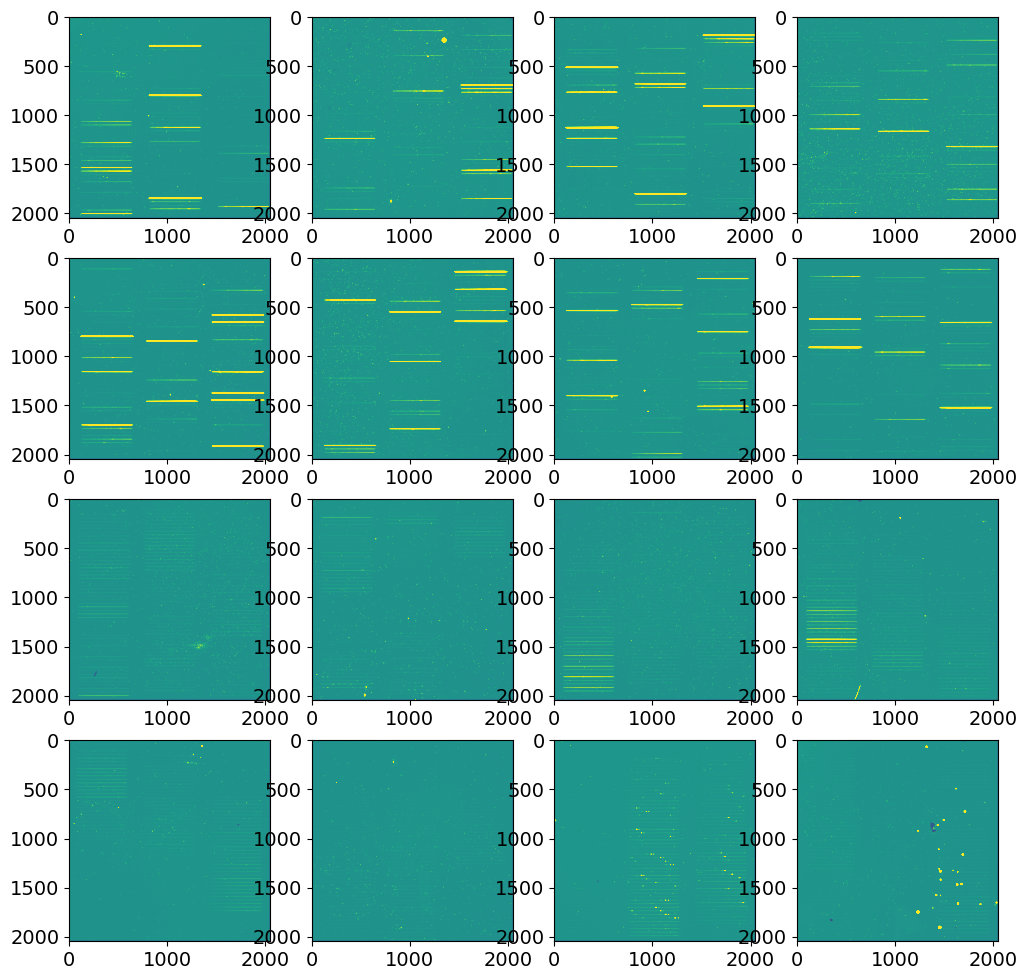

In [10]:
hdu = pyfits.open(slitless_files[0])
print(hdu[0].header)
hdu.info()

fig = plt.figure(figsize=(12,12))

k = 0
for i in range(4):
    for j in range(4):
        name = 'DET%i%i.SCI' % (i+1,j+1)
        #name = 'DET%i%i.CHI2' % (i+1,j+1)
        
        img = hdu[name].data
        print(img.shape)
        head = hdu[name].header
        print(name)
        print(head['CRVAL1'])
        print(head['CRVAL2'])
        print(head['CRPIX1'])
        print(head['CRPIX2'])
        
        #print(np.min(img))
        #print(np.max(img))
        #print(np.mean(img))
        #print(np.median(img))
        #print(np.std(img))
        #print()
        #print(hdu[name].header)
        print()

        
        p = fig.add_subplot(4,4,k+1)
        p.imshow(img,vmin=200,vmax=3000)
        #p.hist(img.flatten(), bins=100)
        #p.set_yscale("log")
        
        k += 1
        
plt.show()




## Plot the image coordinates of the detectors relative to each other

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FITS_DEF= 'le1.sirRawImage'                                                     FITS_VER= '0.2     '                                                            TELESCOP= 'EUCLID  '                                                            INSTRUME= 'NISP    '                                                            VERSION = 'TEST_SC8_NIS_S1'                                                     DATE    = '2022-09-13T23:01:54.142Z'                                            ORIGIN  = 'OU-SIM  '                    

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 2048 / length of data axis 1                          NAXIS2  =                 2048 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     BZERO   =                32768 / offset data range to that of unsigned short    BSCALE  =                    1 / default scaling factor                         EXTNAME = 'DET11.SCI'                                                           CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =     4578.75045083333          

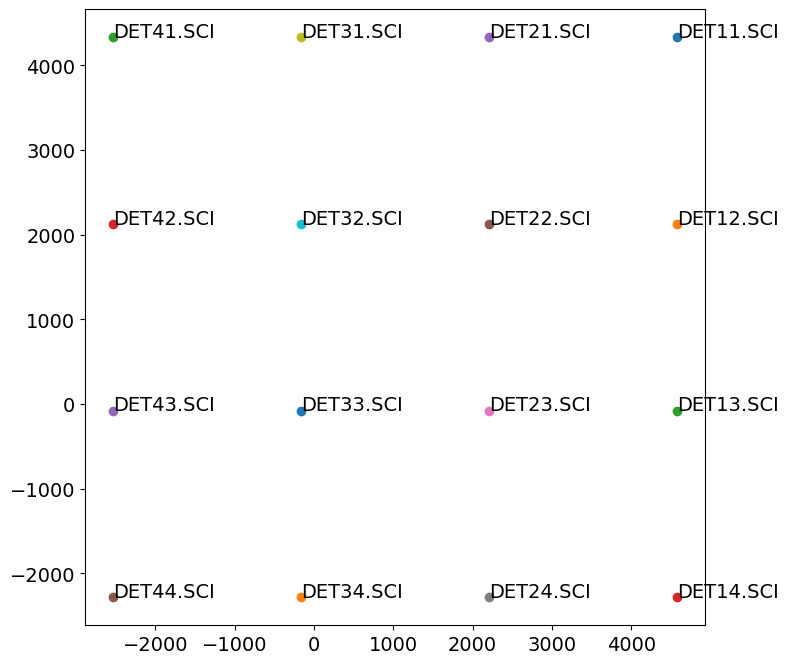

In [11]:
hdu = pyfits.open(slitless_files[0])
print(hdu[0].header)

spec_exptime = hdu[0].header['exptime']
hdu.info()

fig = plt.figure(figsize=(8,8))
p = fig.add_subplot(111)

heads = {}

for i in range(4):
    for j in range(4):
        name = 'DET%i%i.SCI' % (i+1,j+1)
        #name = 'DET%i%i.CHI2' % (i+1,j+1)
        
        #img = hdu[name].data
        head = hdu[name].header
        heads[name] = head
        print(head)
        print(name)
        #print(head['CRVAL1'])
        #print(head['CRVAL2'])
        #print(head['CRPIX1'])
        #print(head['CRPIX2'])
        
        x = head['CRPIX1']
        y = head['CRPIX2']
        print(x,y)
        p.scatter(x,y)
        p.text(x,y,name)
        
        


        
plt.show()

## Read the source catalog

In [13]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

cat = "CATALOG_WP9_INTERMEDIATE_RUN_v2_NewCoord_mod.fits"
print(cat)
primer = Table.read(cat) 
print(primer.colnames)
print(len(primer))

CATALOG_WP9_INTERMEDIATE_RUN_v2_NewCoord_mod.fits
['SOURCE_ID', 'HALO_ID', 'KIND', 'RA', 'DEC', 'RA_MAG', 'DEC_MAG', 'Z_OBS', 'REF_MAG_ABS', 'REF_MAG', 'BULGE_FRACTION', 'BULGE_R50', 'DISK_R50', 'BULGE_NSERSIC', 'BULGE_AXIS_RATIO', 'INCLINATION_ANGLE', 'DISK_ANGLE', 'KAPPA', 'GAMMA1', 'GAMMA2', 'SED_TEMPLATE', 'EXT_LAW', 'EBV', 'HALPHA_LOGFLAM_EXT_MAG', 'HBETA_LOGFLAM_EXT_MAG', 'O2_LOGFLAM_EXT_MAG', 'O3_LOGFLAM_EXT_MAG', 'N2_LOGFLAM_EXT_MAG', 'S2_LOGFLAM_EXT_MAG', 'AV', 'TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG', 'TU_FNU_G_DECAM_MAG', 'TU_FNU_R_DECAM_MAG', 'TU_FNU_I_DECAM_MAG', 'TU_FNU_Z_DECAM_MAG', 'TU_FNU_U_MEGACAM_MAG', 'TU_FNU_R_MEGACAM_MAG', 'TU_FNU_G_JPCAM_MAG', 'TU_FNU_I_PANSTARRS_MAG', 'TU_FNU_Z_PANSTARRS_MAG', 'TU_FNU_Z_HSC_MAG', 'TU_FNU_G_GAIA_MAG', 'TU_FNU_BP_GAIA_MAG', 'TU_FNU_RP_GAIA_MAG', 'TU_FNU_U_LSST_MAG', 'TU_FNU_G_LSST_MAG', 'TU_FNU_R_LSST_MAG', 'TU_FNU_I_LSST_MAG', 'TU_FNU_Z_LSST_MAG', 'TU_FNU_Y_LSST_MAG', 'TU_FNU_U_KIDS_MAG', 'T

In [14]:
primer[:10].show_in_notebook()

idx,SOURCE_ID,HALO_ID,KIND,RA,DEC,RA_MAG,DEC_MAG,Z_OBS,REF_MAG_ABS,REF_MAG,BULGE_FRACTION,BULGE_R50,DISK_R50,BULGE_NSERSIC,BULGE_AXIS_RATIO,INCLINATION_ANGLE,DISK_ANGLE,KAPPA,GAMMA1,GAMMA2,SED_TEMPLATE,EXT_LAW,EBV,HALPHA_LOGFLAM_EXT_MAG,HBETA_LOGFLAM_EXT_MAG,O2_LOGFLAM_EXT_MAG,O3_LOGFLAM_EXT_MAG,N2_LOGFLAM_EXT_MAG,S2_LOGFLAM_EXT_MAG,AV,TU_FNU_VIS_MAG,TU_FNU_Y_NISP_MAG,TU_FNU_J_NISP_MAG,TU_FNU_H_NISP_MAG,TU_FNU_G_DECAM_MAG,TU_FNU_R_DECAM_MAG,TU_FNU_I_DECAM_MAG,TU_FNU_Z_DECAM_MAG,TU_FNU_U_MEGACAM_MAG,TU_FNU_R_MEGACAM_MAG,TU_FNU_G_JPCAM_MAG,TU_FNU_I_PANSTARRS_MAG,TU_FNU_Z_PANSTARRS_MAG,TU_FNU_Z_HSC_MAG,TU_FNU_G_GAIA_MAG,TU_FNU_BP_GAIA_MAG,TU_FNU_RP_GAIA_MAG,TU_FNU_U_LSST_MAG,TU_FNU_G_LSST_MAG,TU_FNU_R_LSST_MAG,TU_FNU_I_LSST_MAG,TU_FNU_Z_LSST_MAG,TU_FNU_Y_LSST_MAG,TU_FNU_U_KIDS_MAG,TU_FNU_G_KIDS_MAG,TU_FNU_R_KIDS_MAG,TU_FNU_I_KIDS_MAG,TU_FNU_J_2MASS_MAG,TU_FNU_H_2MASS_MAG,TU_FNU_KS_2MASS_MAG,VIS,NIR_Y,NIR_J,NIR_H,SED_INDEX,SPECTRA_HDU,MASS_LOG,SFR_LOG,SIGMA_LOG,SIII_9069_LOGFLAM_EXT,SIII_9532_LOGFLAM_EXT,PaschenBETA_LOGFLAM_EXT,PaschenGAMMA_LOGFLAM_EXT,Paschen7_LOGFLAM_EXT,Paschen8_LOGFLAM_EXT,Paschen9_LOGFLAM_EXT,Paschen10_LOGFLAM_EXT,Balmer_GAMMA_LOGFLAM_EXT,Balmer_DELTA_LOGFLAM_EXT,Balmer_EPSILON_LOGFLAM_EXT,Lbol_AGN,Ldisk_AGN,logU,metallicity,alpha,FWHM,HALPHA_LOGFLAM_AGN_EXT,HBETA_LOGFLAM_AGN_EXT,O2_LOGFLAM_AGN_EXT,O3_LOGFLAM_AGN_EXT,N2_LOGFLAM_AGN_EXT,S2_LOGFLAM_AGN_EXT,SIII_9069_LOGFLAM_AGN_EXT,SIII_9532_LOGFLAM_AGN_EXT,PaschenBETA_FLAM_AGN_EXT,PaschenGAMMA_FLAM_AGN_EXT,Paschen7_FLAM_AGN_EXT,Paschen8_FLAM_AGN_EXT,Paschen9_FLAM_AGN_EXT
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1191,0,1,228.74652,6.244,228.74652,6.244,0.1,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.5,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.560469383868375e-06,6.043357125747614e-06,1.1065422134118237e-05,2.124431167400817e-05,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.87920103189823,21.946804352059324,21.290080033867067,20.58189333924539,0,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,42.6,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
1,1822,0,1,228.74652,6.247,228.74652,6.247,0.2,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.25,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.3678139753534368e-06,4.190686633839127e-06,6.6663631344253864e-06,1.1859532869635476e-05,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.964131051168174,22.34428703276546,21.840277582156133,21.21483104221333,1,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,43.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
2,2806,0,1,228.74652,6.25,228.74652,6.25,0.6,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2405649632756416e-06,2.099637587271171e-06,2.3382084431336903e-06,3.282033915403543e-06,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.665951221459235,23.094639152964227,22.977791939022264,22.609642338526854,2,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,43.6,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
3,3011,0,1,228.74652,6.253,228.74652,6.253,0.1,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.75,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.4898965830535686e-05,4.3777215482665326e-05,9.258969966782651e-05,0.00019338173160169024,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-9

## Plot the magnitude histogram of sources

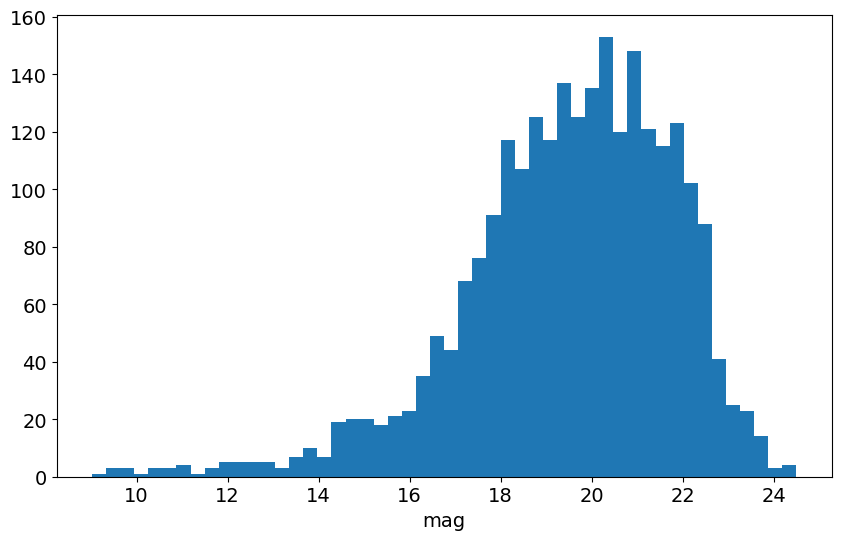

In [20]:
primer['TU_FNU_Y_NISP_MAG'] # Jy
primer['TU_FNU_J_NISP_MAG'] # Jy
primer['TU_FNU_H_NISP_MAG'] # Jy
primer['NIR_Y'] # mag
primer['NIR_J'] # mag
primer['NIR_H'] # mag

fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.hist(primer['TU_FNU_H_NISP_MAG'],bins=50)
p1.hist(primer['NIR_H'],bins=50)
p1.set_xlabel("mag")
plt.show()

## Plot the RA and Dec distribution across the detectors

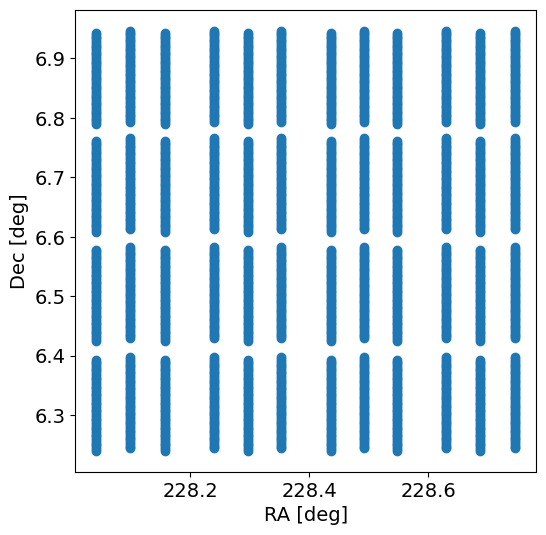

In [19]:
fig = plt.figure()

p1 = fig.add_subplot(111)
p1.scatter(primer['RA'],primer['DEC'])
p1.set_aspect(1.)
p1.set_xlabel("RA [deg]")
p1.set_ylabel("Dec [deg]")

plt.show()

In [17]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))
direct_thumbnail_files = glob.glob('NIS_catalog_file_??.thm.beamA.fits')
direct_thumbnail_files.sort()
print(direct_thumbnail_files)
print(len(direct_thumbnail_files))

['NIS_catalog_file_11.thm.beamA.fits', 'NIS_catalog_file_12.thm.beamA.fits', 'NIS_catalog_file_13.thm.beamA.fits', 'NIS_catalog_file_14.thm.beamA.fits', 'NIS_catalog_file_21.thm.beamA.fits', 'NIS_catalog_file_22.thm.beamA.fits', 'NIS_catalog_file_23.thm.beamA.fits', 'NIS_catalog_file_24.thm.beamA.fits', 'NIS_catalog_file_31.thm.beamA.fits', 'NIS_catalog_file_32.thm.beamA.fits', 'NIS_catalog_file_33.thm.beamA.fits', 'NIS_catalog_file_34.thm.beamA.fits', 'NIS_catalog_file_41.thm.beamA.fits', 'NIS_catalog_file_42.thm.beamA.fits', 'NIS_catalog_file_43.thm.beamA.fits', 'NIS_catalog_file_44.thm.beamA.fits']
16


## Map the sources the sources from the catalog to the detectors 

1 1


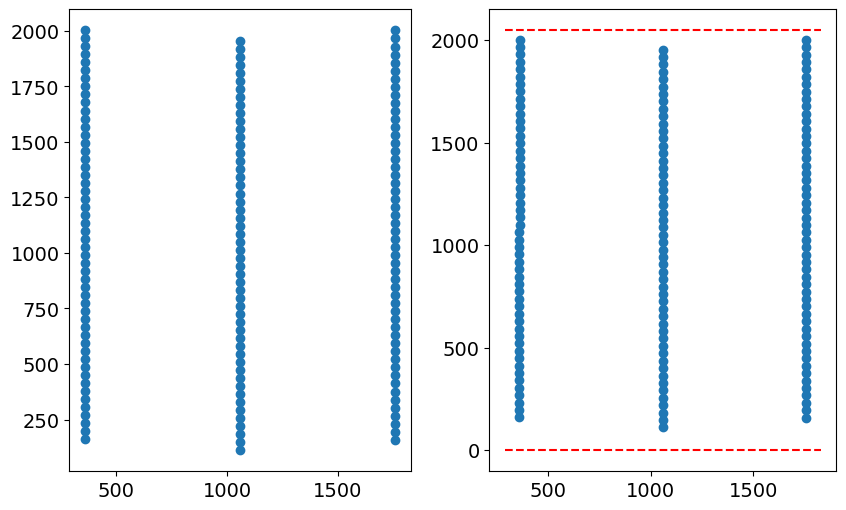

[1191, 1822, 2806, 3011, 3083, 3084, 3224, 3575, 3576, 3716, 3785, 3851, 3924, 3994, 4211, 4213, 4342, 4344, 4485, 4831, 4903, 4906, 5113, 5116, 5325, 5391, 5461, 5471, 5612, 5680, 5688, 5741, 5812, 5818, 5825, 5882, 5952, 5957, 6021, 6091, 6093, 6095, 6162, 6168, 6173, 6304, 6314, 6325, 6344, 6395, 6442, 6511, 16825, 16830, 16881, 16913, 16958, 17151, 17159, 17173, 17174, 17176, 17193, 17198, 17218, 17220, 17233, 17261, 17310, 17366, 17376, 17501, 17586, 17587, 17589, 17590, 17649, 17650, 17652, 17654, 17713, 17716, 17726, 17802, 17858, 17873, 17882, 17887, 17896, 17903, 17905, 17910, 17943, 17946, 17949, 17959, 17961, 17980, 18013, 18142, 18201, 18209, 18215, 18276, 31014, 31082, 31225, 31361, 31574, 31645, 31924, 32412, 32553, 32555, 32692, 32693, 33252, 33333, 33536, 33614, 33815, 33824, 33954, 33960, 33973, 33975, 34100, 34164, 34378, 34386, 34516, 34595, 34665, 34688, 34733, 34746, 34794, 34809, 34932, 34943, 34947, 35012, 35051, 35085, 35157, 35356, 35357, 35371, 35375, 35388, 3

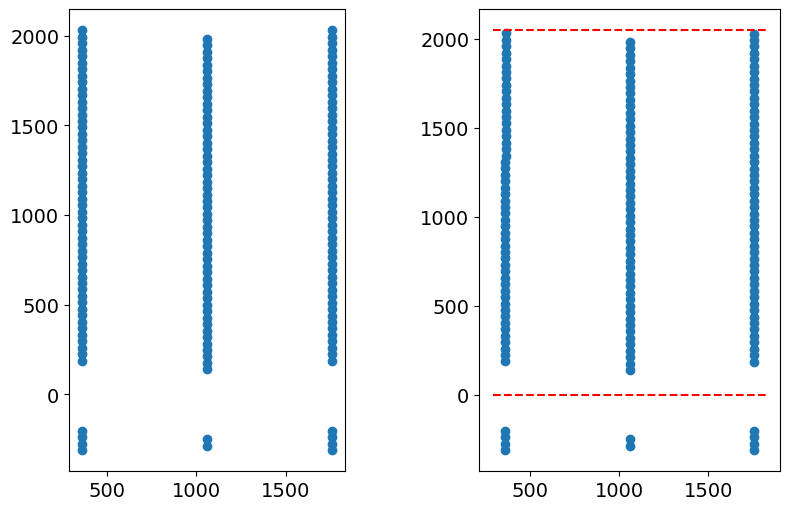

[6344, 6395, 6442, 6511, 6662, 6676, 6695, 6696, 6741, 6800, 6873, 7013, 7026, 7053, 7064, 7093, 7158, 7165, 7219, 7288, 7360, 7372, 7375, 7393, 7400, 7460, 7497, 7507, 7513, 7572, 7583, 7634, 7646, 7703, 7708, 7717, 7734, 7746, 7755, 7765, 7769, 7806, 7811, 7813, 7852, 7864, 7867, 7914, 7916, 7931, 8063, 8094, 8119, 8125, 8153, 8175, 18215, 18276, 18277, 18297, 18332, 18333, 18340, 18380, 18432, 18486, 18490, 18496, 18497, 18505, 18582, 18587, 18615, 18617, 18673, 18765, 18774, 18838, 18840, 18857, 19041, 19602, 19952, 21354, 21424, 21491, 21632, 21701, 21705, 21984, 22054, 22401, 22545, 22751, 22754, 23106, 23112, 23180, 23465, 23809, 23817, 23950, 24012, 24165, 24227, 24233, 24302, 24305, 24436, 24587, 35456, 35492, 35498, 35514, 35563, 35566, 35570, 35766, 35775, 35790, 35812, 35848, 35859, 35915, 35927, 35934, 35985, 35991, 36051, 36052, 36053, 36063, 36096, 36115, 36158, 36163, 36164, 36172, 36272, 36338, 36412, 36431, 36434, 36459, 36478, 36487, 36501, 36554, 36560, 36614, 36617

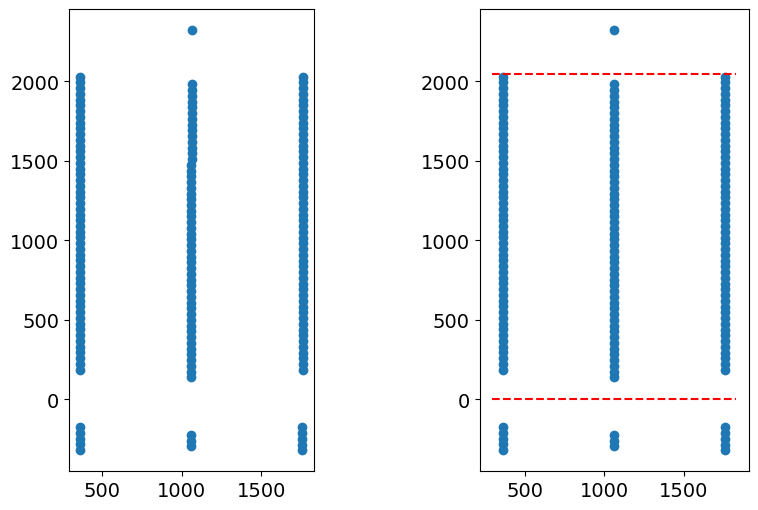

[8094, 8119, 8125, 8153, 8175, 8216, 8276, 8284, 8440, 8479, 8480, 8488, 8491, 8513, 8541, 8548, 8549, 8567, 8624, 8685, 8694, 8754, 8780, 8797, 8842, 8865, 8877, 8920, 8976, 8978, 8986, 9031, 9040, 9043, 9106, 9126, 9143, 9163, 9169, 9197, 9201, 9215, 9245, 9266, 9295, 9334, 10853, 11905, 11971, 12043, 12394, 12675, 12743, 12745, 12813, 13305, 13310, 24305, 24436, 24587, 24785, 24787, 24935, 25004, 25006, 25062, 25219, 25226, 25277, 25287, 25351, 25493, 25552, 25586, 25593, 25621, 25622, 25636, 25639, 25642, 25697, 25707, 25709, 25766, 25843, 25917, 25945, 25960, 25978, 26051, 26183, 26291, 26324, 26357, 26401, 26465, 26541, 26634, 26638, 26677, 26685, 26686, 26694, 26715, 26757, 26818, 26881, 26888, 26892, 26956, 26968, 26983, 27002, 36907, 36910, 36916, 36930, 36935, 37031, 37033, 37034, 37037, 37044, 37121, 37129, 37131, 37146, 37151, 37190, 37203, 37263, 37293, 37319, 37458, 37510, 37548, 37551, 37579, 37592, 37612, 37618, 37625, 37640, 37667, 37676, 37743, 39481, 40182, 40463, 40

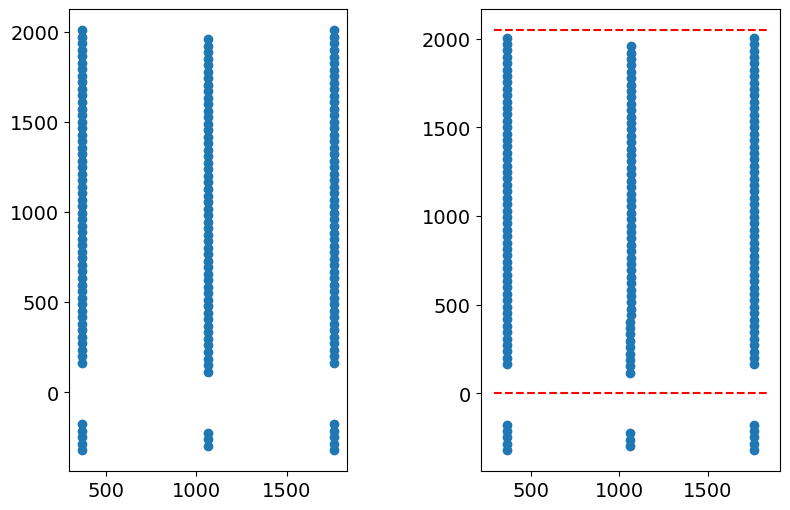

[12743, 12745, 12813, 13305, 13310, 13371, 13441, 13581, 13584, 13660, 13725, 13732, 13796, 13936, 14006, 14010, 14084, 14142, 14146, 14281, 14491, 14497, 14563, 14703, 14842, 15058, 15062, 15136, 15331, 15408, 15474, 15482, 15541, 15545, 15555, 15759, 15900, 15906, 16121, 16142, 16184, 16261, 16262, 16384, 16460, 16462, 16473, 16499, 16515, 16525, 16535, 16544, 16670, 16805, 16810, 16812, 16816, 26956, 26968, 26983, 27002, 27010, 27012, 27016, 27029, 27061, 27063, 27071, 27173, 27319, 27346, 27370, 27377, 27388, 27404, 27456, 27522, 27525, 27536, 27607, 27657, 27667, 27680, 27682, 27693, 27699, 27711, 27713, 27715, 27724, 27738, 27743, 27752, 27831, 27877, 27878, 28083, 28093, 28118, 28161, 28166, 28219, 28222, 28226, 28228, 28911, 29402, 29541, 30733, 30803, 30942, 30943, 42281, 42422, 42435, 42562, 42564, 42782, 42843, 43191, 43193, 43837, 43906, 44032, 44036, 44044, 44102, 44138, 44145, 44245, 44247, 44319, 44387, 44389, 44391, 44525, 44531, 44539, 44605, 44614, 44733, 44736, 44822

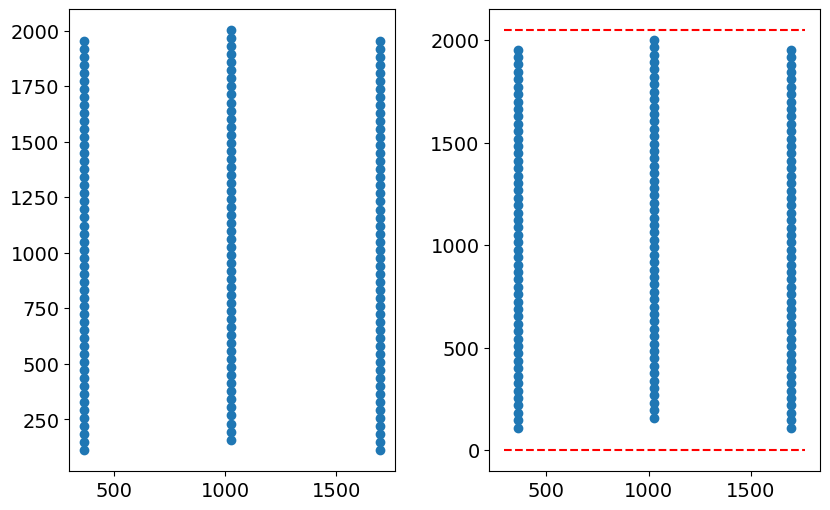

[45645, 45660, 45737, 45790, 45791, 45867, 45907, 45941, 45950, 45957, 45964, 45974, 45997, 46002, 46014, 46071, 46084, 46148, 46154, 46201, 46211, 46214, 46220, 46244, 46262, 46275, 46290, 46314, 46315, 46343, 46355, 46361, 46363, 46376, 46437, 46488, 46584, 46587, 46602, 46628, 46632, 46646, 46647, 46670, 46693, 46696, 46707, 46768, 46835, 46913, 46926, 46970, 62322, 62325, 62326, 62376, 62379, 62443, 62452, 62653, 62727, 62734, 62793, 62946, 63080, 63088, 63091, 63143, 63153, 63161, 63288, 63351, 63359, 63362, 63388, 63389, 63390, 63407, 63437, 63440, 63442, 63445, 63492, 63500, 63503, 63576, 63738, 63749, 63771, 63775, 63793, 63809, 63854, 63983, 63985, 63988, 64067, 64083, 64085, 64095, 64114, 64117, 64129, 64142, 73957, 73968, 73974, 74005, 74006, 74068, 74133, 74137, 74146, 74243, 74351, 74360, 74380, 74411, 74430, 74481, 74485, 74490, 74493, 74498, 74556, 74567, 74573, 74579, 74582, 74594, 74634, 74636, 74644, 74692, 74702, 74705, 74716, 74737, 74771, 74831, 74851, 74901, 74916

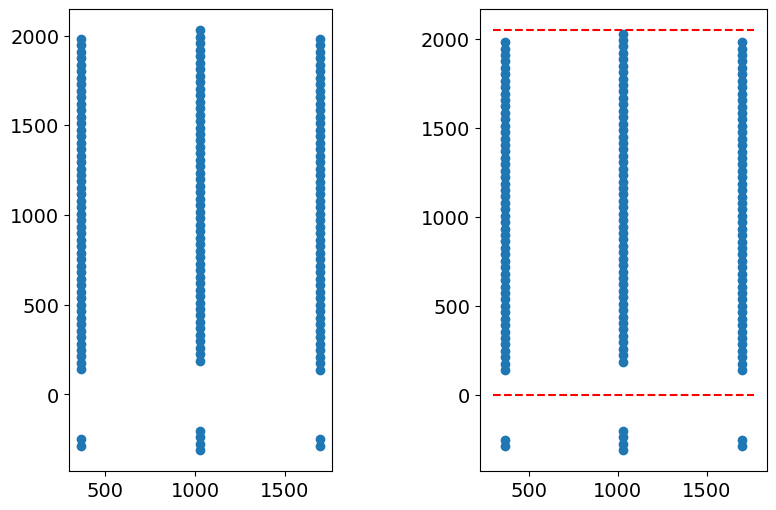

[46926, 46970, 46987, 47007, 47016, 47069, 47075, 47087, 47127, 47137, 47183, 47188, 48722, 48792, 49141, 49632, 49705, 49774, 49914, 49982, 50053, 50404, 51034, 51171, 51241, 51243, 51523, 51592, 51600, 51735, 51803, 51806, 51941, 52152, 52158, 52294, 52433, 52644, 52653, 52712, 52720, 52722, 52927, 52935, 53073, 53136, 53142, 53208, 53224, 53287, 53352, 53551, 53552, 53692, 64114, 64117, 64129, 64142, 64146, 64163, 64413, 64423, 64435, 64467, 64481, 64543, 64553, 64627, 64681, 64692, 64763, 64791, 64795, 64834, 64847, 64870, 64872, 64908, 64915, 64929, 64965, 64976, 65032, 65129, 65141, 65149, 65167, 65186, 65191, 65193, 65209, 65211, 65230, 65245, 65263, 65277, 65315, 65385, 65388, 65396, 65406, 65454, 65472, 65495, 65514, 65542, 65543, 65551, 65557, 65570, 75042, 75090, 75111, 75115, 75122, 75123, 75136, 75182, 75195, 75269, 75272, 75275, 75371, 75396, 75418, 75441, 75531, 75553, 75741, 76091, 77353, 77771, 78192, 78332, 78543, 78821, 79171, 79316, 79454, 79531, 79595, 79872, 80162

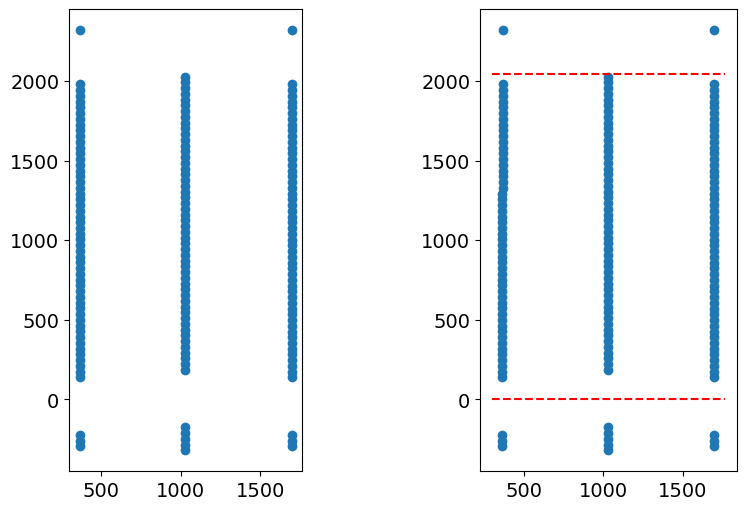

[53551, 53552, 53692, 53704, 53841, 53915, 53945, 53990, 54048, 54254, 54266, 54313, 54344, 54345, 54391, 54467, 54470, 54471, 54617, 54650, 54661, 54684, 54765, 54833, 54888, 54959, 54971, 54979, 55023, 55038, 55099, 55115, 55177, 55240, 55245, 55316, 55330, 55421, 55442, 55446, 55529, 55598, 55660, 55677, 55680, 55687, 55690, 55702, 55734, 55745, 55751, 55762, 55769, 55827, 55836, 55881, 65542, 65543, 65551, 65557, 65570, 65585, 65616, 65626, 65668, 65735, 65754, 65844, 65858, 65873, 65877, 65897, 65914, 65952, 65982, 65994, 66036, 66048, 66105, 67622, 67901, 67903, 68182, 68393, 68531, 68882, 69163, 69444, 69515, 69583, 69651, 69723, 69726, 70144, 70362, 70422, 70562, 70772, 70843, 70846, 70913, 70981, 70984, 71053, 71059, 71261, 71335, 71406, 71551, 71771, 71894, 72031, 72102, 82190, 82259, 82300, 82324, 82344, 82391, 82397, 82404, 82464, 82471, 82537, 82617, 82628, 82690, 82693, 82743, 82746, 82757, 82829, 82889, 82952, 82963, 82975, 82997, 83013, 83016, 83024, 83096, 83105, 83114

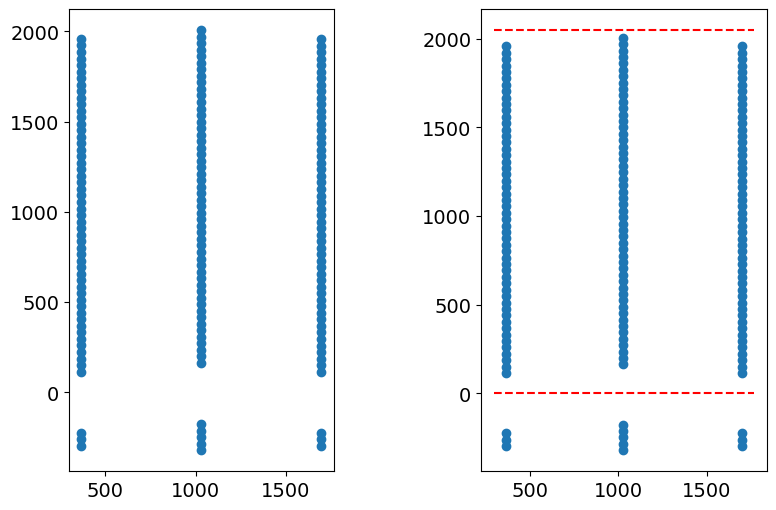

[55769, 55827, 55836, 55881, 55885, 55934, 56014, 56017, 56020, 56024, 56046, 56049, 56051, 56109, 56131, 56157, 56176, 56353, 56377, 56378, 56428, 56439, 56446, 56482, 56490, 56491, 56524, 56571, 56648, 57051, 58242, 58802, 58872, 59082, 59712, 59923, 60483, 60485, 60555, 60625, 60762, 61251, 61260, 61326, 61602, 61614, 61681, 61755, 62027, 62094, 62105, 62162, 62235, 62241, 62303, 71551, 71771, 71894, 72031, 72102, 72120, 72172, 72173, 72184, 72188, 72314, 72393, 72396, 72455, 72476, 72526, 72602, 72802, 72803, 72820, 72823, 72844, 72846, 72849, 72957, 72960, 73084, 73152, 73154, 73160, 73191, 73199, 73243, 73247, 73258, 73259, 73310, 73373, 73378, 73435, 73444, 73446, 73527, 73540, 73542, 73615, 73643, 73659, 73667, 73722, 73727, 73787, 73905, 73908, 73915, 73928, 73941, 83873, 83939, 83952, 84006, 84010, 84027, 84037, 84052, 84081, 84090, 84096, 84105, 84121, 84122, 84164, 84178, 84179, 84181, 84212, 84217, 84223, 84289, 84301, 84306, 84360, 84367, 84369, 84375, 84383, 84402, 84426

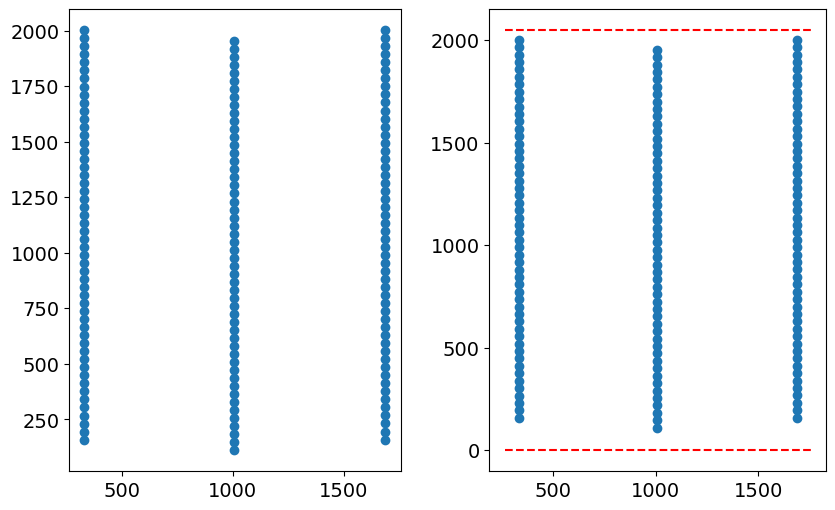

[120049, 120427, 121372, 121949, 122138, 122337, 122516, 122715, 122884, 122894, 123073, 123471, 123660, 123849, 124028, 124595, 124794, 124983, 125361, 157092, 157848, 158415, 158982, 159370, 160136, 160693, 161250, 161260, 162583, 163160, 195647, 196025, 196592, 196980, 197348, 197726, 197736, 197915, 197925, 198313, 198671, 198681, 198880, 199049, 199248, 199437, 199616, 199626, 199636, 199815, 199825, 200939, 161091, 161469, 162225, 162424, 162792, 162812, 163170, 163359, 163548, 163558, 163747, 163936, 163946, 164145, 164324, 164344, 164523, 164533, 199268, 199278, 199646, 199845, 200024, 200223, 200402, 200422, 200601, 200800, 200810, 201198, 201347, 201377, 201556, 201566, 201745, 201914, 201954, 202322, 202501, 202511, 202700, 202899, 203257, 203834, 204222, 237256, 238022, 238032, 238201, 238778, 238967, 239146, 540424, 540593, 540802, 541190, 541548, 541558, 541578, 541747, 541956, 542125, 542324, 542682, 542692, 542881, 543060, 543070, 543090, 543806, 543826, 543836, 543995,

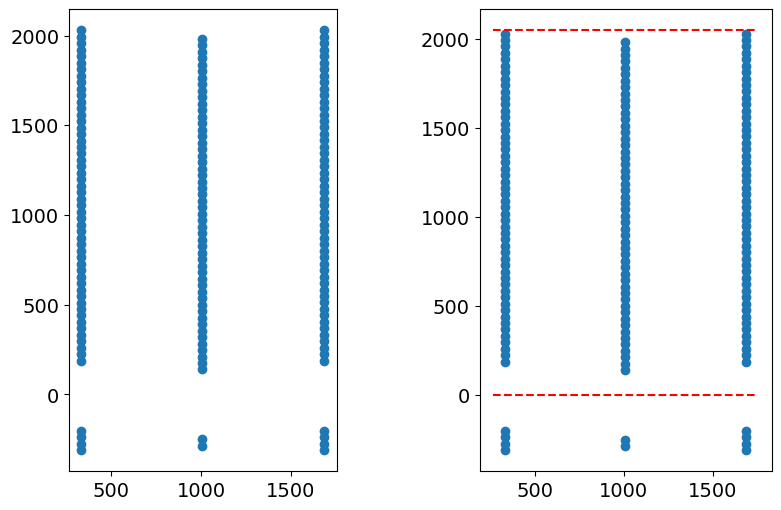

[199636, 199815, 199825, 200939, 201128, 201148, 201526, 232690, 234391, 235336, 235346, 235724, 235913, 236112, 236659, 237047, 237057, 237236, 237246, 237415, 237624, 237803, 238191, 238380, 238559, 238947, 268977, 269365, 269733, 269743, 270867, 271255, 271434, 271633, 272956, 273155, 273324, 273334, 274100, 274458, 274468, 274478, 274846, 275035, 275403, 275413, 275423, 275791, 276557, 277691, 278258, 278437, 278825, 309044, 310188, 310745, 238967, 239146, 239186, 239544, 239902, 240091, 270897, 272071, 272439, 272449, 272807, 272827, 273165, 273185, 273195, 273543, 273563, 273921, 273931, 273941, 274339, 275065, 275075, 275433, 275443, 275811, 276010, 276378, 276398, 276597, 276607, 277144, 277154, 277164, 277343, 277542, 277701, 277711, 277900, 278079, 278089, 278109, 278119, 278268, 278298, 278308, 278457, 278467, 278676, 278686, 278855, 278865, 279233, 279621, 577457, 577487, 577835, 577845, 577865, 578392, 578402, 578591, 578959, 579347, 579377, 579745, 579755, 579934, 580292,

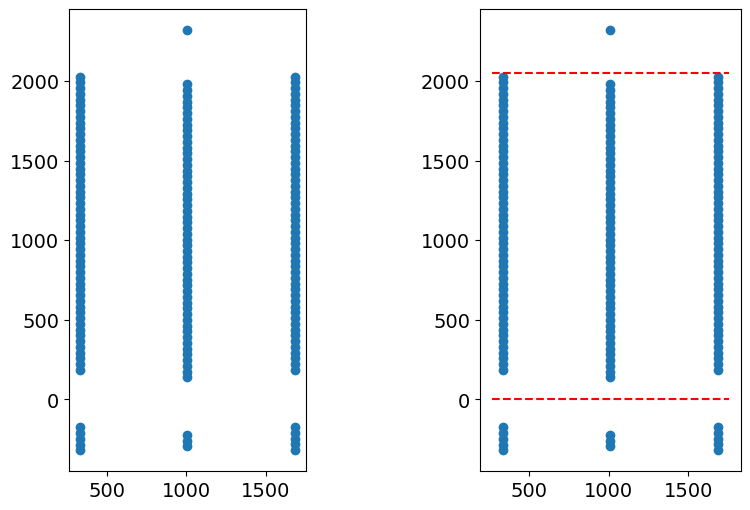

[278437, 278825, 309044, 310188, 310745, 311312, 311322, 311889, 312446, 313590, 314346, 314545, 314734, 314923, 315102, 315301, 315480, 315490, 315669, 315679, 317947, 343819, 344197, 345331, 346843, 347241, 347599, 347977, 349111, 349300, 349877, 350245, 350454, 350623, 350643, 350822, 351190, 351389, 351399, 351568, 351757, 351946, 351956, 352712, 352891, 352901, 353100, 353458, 353468, 353478, 354025, 354045, 354234, 354791, 354990, 535092, 536614, 278865, 279233, 279621, 279780, 310964, 311720, 312118, 313799, 313998, 314406, 314555, 314565, 314764, 314953, 315311, 315520, 315530, 315689, 315699, 315709, 315878, 315898, 316067, 316077, 316087, 316097, 316266, 316276, 316445, 316455, 316644, 317032, 317052, 317201, 317221, 317390, 317430, 317589, 317609, 317619, 317778, 317788, 317987, 318176, 318335, 318365, 318554, 318753, 318922, 318932, 319111, 319320, 348385, 348395, 348763, 348773, 693709, 125047, 125426, 125614, 125804, 125992, 125994, 126182, 126183, 126370, 126559, 126565,

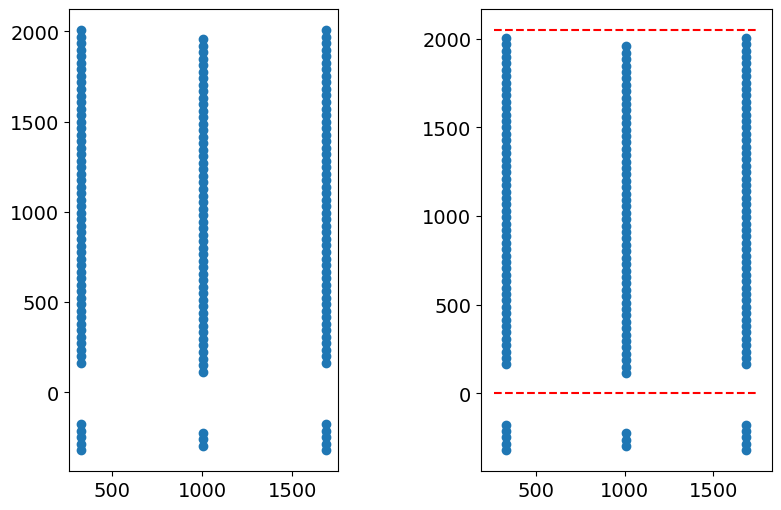

[354234, 354791, 354990, 535092, 536614, 537748, 538504, 538882, 539260, 539628, 540016, 541339, 543418, 543607, 570991, 572881, 573637, 573657, 574035, 574393, 574960, 575338, 575348, 575527, 575726, 575905, 575925, 576094, 576303, 576661, 576671, 577984, 578173, 578362, 578571, 578740, 578949, 579118, 579327, 579516, 579685, 579874, 580083, 580272, 123491, 124247, 124267, 124804, 124993, 125371, 125381, 125391, 125401, 125789, 126535, 126724, 160902, 348385, 348395, 348763, 348773, 349141, 349907, 349917, 349927, 350305, 350315, 350653, 350663, 350693, 351041, 351051, 351071, 351409, 351787, 351797, 351986, 352165, 352175, 352185, 352205, 352354, 352364, 352384, 352732, 352921, 352961, 353140, 353150, 353299, 353319, 353329, 353339, 353508, 353876, 353886, 353896, 354075, 354085, 354463, 354821, 355000, 355010, 355199, 355388, 355408, 536246, 538912, 539280, 539300, 539668, 540056, 200263, 200267, 200459, 200460, 200641, 200835, 200837, 200838, 201213, 201216, 201397, 201401, 201402,

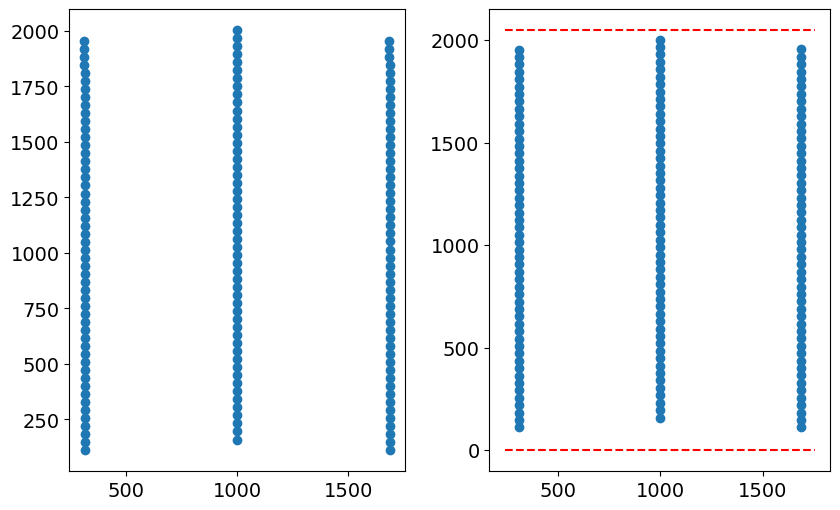

[205376, 205378, 205749, 205754, 205756, 205939, 205941, 206320, 206322, 206507, 206508, 206510, 206511, 207267, 238066, 238629, 238822, 238823, 239203, 239385, 239574, 239578, 239768, 239958, 239959, 239964, 271703, 272841, 273215, 273220, 273223, 273225, 273597, 273603, 273975, 273977, 273983, 274357, 274735, 275114, 275488, 275489, 275490, 275492, 275493, 275494, 275672, 275865, 275866, 275868, 275873, 276056, 353353, 353355, 353361, 353727, 353731, 353732, 353921, 354105, 354113, 354114, 354115, 354117, 354300, 354302, 354487, 354490, 354491, 354493, 354867, 354868, 354870, 354872, 355050, 355054, 355056, 355428, 355436, 355438, 355439, 538186, 538568, 538569, 538942, 539325, 539328, 539698, 539706, 540454, 540458, 540459, 540840, 541216, 541217, 541218, 541219, 541598, 541971, 541976, 541978, 542155, 542727, 542729, 692595, 692600, 692789, 692790, 692973, 692980, 693351, 693356, 693358, 693546, 693547, 693549, 693736, 205004, 205383, 205757, 205760, 206137, 206138, 206139, 206140,

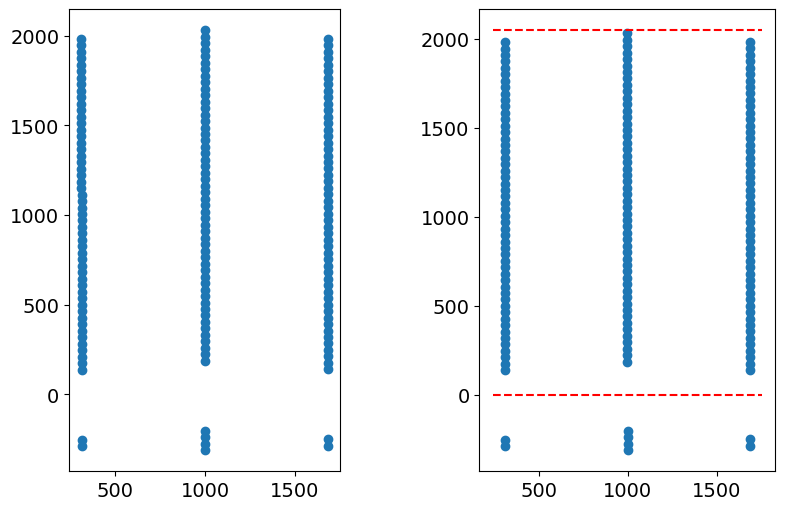

[275873, 276056, 276434, 276435, 276627, 276629, 276806, 276813, 276999, 277002, 277004, 277006, 277184, 277384, 277562, 277566, 277567, 277751, 277755, 277762, 277949, 278134, 278135, 278137, 278318, 278324, 278327, 278329, 278330, 278512, 278515, 278519, 278704, 278707, 278708, 278885, 278896, 278897, 279078, 279085, 279269, 279274, 279458, 279461, 279464, 279646, 279647, 279651, 279836, 279837, 279838, 279841, 279842, 312148, 541978, 542155, 542727, 542729, 542917, 543107, 543289, 543295, 543485, 543488, 543667, 543674, 543675, 543676, 543861, 543867, 544050, 544240, 544241, 544246, 544428, 544431, 544435, 544612, 544621, 544806, 544807, 544809, 544813, 544990, 544994, 544997, 545000, 545001, 545002, 545183, 545184, 545186, 545189, 545191, 545368, 545372, 545562, 545563, 545565, 545567, 545750, 545940, 545944, 545945, 545946, 545947, 546129, 546321, 546323, 546502, 278525, 278901, 278903, 278905, 279281, 279282, 279285, 279654, 279661, 279662, 318967, 318968, 319343, 319348, 319726,

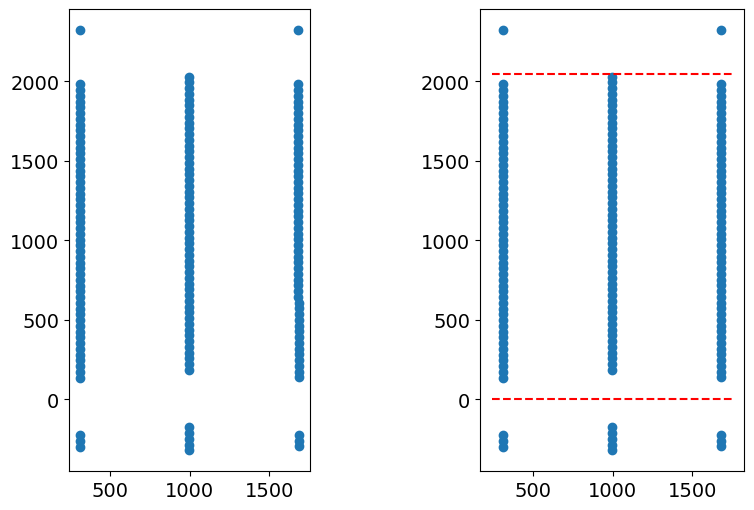

[279841, 279842, 312148, 312908, 313288, 313660, 313666, 314420, 314423, 314424, 314799, 314802, 314803, 315179, 315182, 315365, 315554, 315558, 315561, 315932, 315933, 315939, 316117, 316310, 316317, 316503, 316688, 316690, 316693, 316694, 316695, 316878, 317067, 317068, 317069, 317072, 317257, 317261, 317445, 317446, 317447, 317449, 317450, 317451, 317629, 317636, 317824, 317826, 317827, 318203, 318207, 318394, 318578, 318579, 318586, 318774, 545947, 546129, 546321, 546323, 546502, 546510, 546514, 546697, 546700, 546701, 546703, 546884, 546890, 547075, 547266, 547267, 547270, 547447, 547452, 547640, 547642, 547647, 547830, 547831, 547837, 548018, 548019, 548025, 548207, 548209, 548211, 548214, 548399, 548401, 548402, 548403, 548587, 548591, 548775, 548776, 548778, 548782, 548966, 548968, 548971, 549158, 549344, 549534, 549535, 549536, 549538, 549724, 549725, 550103, 550104, 550105, 616060, 546899, 547274, 547276, 547277, 547278, 547650, 547652, 547655, 547656, 548029, 548032, 548034,

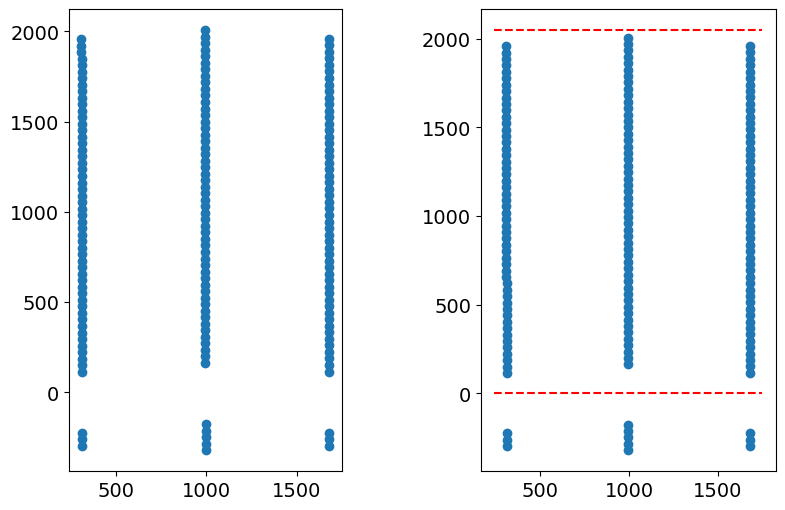

[318578, 318579, 318586, 318774, 318775, 318956, 318958, 319141, 319145, 319146, 319153, 319335, 319523, 319524, 319525, 319527, 319530, 319531, 319716, 319718, 319719, 319904, 320093, 320096, 320279, 320284, 320471, 320472, 320475, 320476, 320659, 320660, 320854, 321041, 321043, 321418, 321799, 349947, 350331, 350703, 350711, 351081, 351090, 351459, 351469, 351845, 352026, 352219, 352220, 352224, 352601, 352603, 352976, 352978, 352983, 549725, 550103, 550104, 550105, 616060, 616437, 617192, 617193, 617194, 617195, 617196, 617197, 617572, 617948, 617951, 652339, 652346, 653103, 653473, 653477, 653479, 653484, 653851, 653856, 653857, 654238, 654616, 654617, 654619, 654992, 654994, 654997, 655178, 655363, 655370, 655374, 655557, 655741, 655745, 655747, 655751, 655753, 655935, 690142, 690516, 690894, 690899, 691280, 691656, 692034, 692037, 692038, 692222, 692406, 692410, 692412, 692413, 278531, 278538, 278908, 279286, 279289, 321626, 321627, 321999, 322001, 322382, 322385, 322758, 322759,

In [24]:
# Loops through all detectors

from astropy import wcs

os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))

thumb_temp = 'NIS_catalog_file_%s.thm.beamA.fits'
wcs_temp = "../Euclid_DET%s.SCI_wcs.fits"

det_dict = {}

for i in range(0,4): 
    for j in range(0,4):
        print(i+1,j+1)
        num = '%i%i' % (i+1,j+1)

        head = heads['DET%s.SCI' % (num)]

        nhdu = pyfits.PrimaryHDU()                                                              
        nhdu.header = head  
        nhdu.header.tofile(wcs_temp % (num),overwrite=True)
        #print(head)
        #print()
        #print(nhdu)                                                                            
                                                                                                                                                                               
        w = wcs.WCS(nhdu)  

        hdu = pyfits.open(thumb_temp % (num))
        sources = [h.header['EXTNAME'] for h in hdu[1:]]
        det_thumb_tbl = Table([sources], names=['SOURCE_ID'])
        
        det_tbl = join(det_thumb_tbl, primer, keys='SOURCE_ID')

        world = [[ra,dec] for ra,dec in det_tbl['RA','DEC']]
        pixcrd = w.wcs_world2pix(world, 0)                                              

        det_tbl['X_PIX'] = pixcrd[:,0]
        det_tbl['Y_PIX'] = pixcrd[:,1]
        
        fig = plt.figure()
        
        p1 = fig.add_subplot(121)
        p1.scatter(det_tbl['X_PIX'],det_tbl['Y_PIX'])
        p1.set_aspect("equal")
        #p1.set_xlim()
        
        p2 = fig.add_subplot(122)
        p2.scatter(det_tbl['X_PIX'],det_tbl['Y_PIX'])
        
        x0,x1 = p2.get_xlim()
        
        p2.plot([x0,x1],[0,0],"--",c="r")
        p2.plot([x0,x1],[2048,2048],"--",c="r")        
        p2.set_aspect("equal")        
        
        plt.show()
        
        print(sources)
        print()
        print()
        
        det_dict[num] = det_tbl

print(det_dict)

In [ ]:
#################################
# single detector, no longer used
#################################

from astropy import wcs

os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))

head = heads['DET11.SCI']

nhdu = pyfits.PrimaryHDU()                                                              
nhdu.header = head  
nhdu.header.tofile('../Euclid_DET11.SCI_wcs.fits',overwrite=True)                                             
print(nhdu)                                                                            
                                                                                                                                                                               
w = wcs.WCS(nhdu)  

hdu = pyfits.open(direct_thumbnail_files[0])
sources = [h.header['EXTNAME'] for h in hdu[1:]]
det11_thumb_tbl = Table([sources], names=['SOURCE_ID'])
    
det11_tbl = join(det11_thumb_tbl, primer, keys='SOURCE_ID')

world = [[ra,dec] for ra,dec in det11_tbl['RA','DEC']]
pixcrd = w.wcs_world2pix(world, 0)                                              

det11_tbl['X_PIX'] = pixcrd[:,0]
det11_tbl['Y_PIX'] = pixcrd[:,1]

print(det11_tbl)

## Print each of the detectors WCS header information

In [21]:
from astropy import wcs

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
wcs_temp = "Euclid_DET%s.SCI_wcs.fits"

for i in range(0,4): 
    for j in range(0,4):
        print(i+1,j+1)
        num = '%i%i' % (i+1,j+1)
        hdu = pyfits.open(wcs_temp % (num), ignore_missing_simple=True)    
        head = hdu[0].header
        #print(head)
        print(head['CRVAL1'],head['CRVAL2'],head['CRPIX1'],head['CRPIX2'])

1 1
228.39419187752 6.5903912393221 4578.75045083333 4331.37522541667
1 2
228.39419187752 6.5903912393221 4578.75045083333 2126.45840847222
1 3
228.39419187752 6.5903912393221 4578.75045083333 -78.4584084722222
1 4
228.39419187752 6.5903912393221 4578.75045083333 -2283.37522541667
2 1
228.39419187752 6.5903912393221 2208.91681694444 4331.37522541667
2 2
228.39419187752 6.5903912393221 2208.91681694444 2126.45840847222
2 3
228.39419187752 6.5903912393221 2208.91681694444 -78.4584084722222
2 4
228.39419187752 6.5903912393221 2208.91681694444 -2283.37522541667
3 1
228.39419187752 6.5903912393221 -160.916816944444 4331.37522541667
3 2
228.39419187752 6.5903912393221 -160.916816944444 2126.45840847222
3 3
228.39419187752 6.5903912393221 -160.916816944444 -78.4584084722222
3 4
228.39419187752 6.5903912393221 -160.916816944444 -2283.37522541667
4 1
228.39419187752 6.5903912393221 -2530.75045083333 4331.37522541667
4 2
228.39419187752 6.5903912393221 -2530.75045083333 2126.45840847222
4 3
228.

In [25]:
# Loops through all detectors

os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))

thumb_temp = 'NIS_catalog_file_%s.thm.beamA.fits'
box_hw = 11
scale = 1e4 # arbitrary
verb = 1

for i in range(0,4): 
    for j in range(0,4):
        print(i+1,j+1)
        num = '%i%i' % (i+1,j+1)

        head1 = heads['DET%s.SCI' % (num)]

        gain = head1['GAIN_DET']
        direct = "Euclid_DET%s.fits" % (num)

        data = np.zeros((2048,2048)) 
        err = np.zeros((2048,2048)) 
        dq = np.ones((2048,2048)) 

        #data += 1e-15

        hdu = pyfits.open(thumb_temp % (num))
        print(thumb_temp % (num))
        print(len(hdu))
        #print(hdu[0].header)
        #print(hdu['1191'].header)
        #print(hdu.info())
        
        det_tbl = det_dict[num]

        for k,h in enumerate(hdu[1:]):
            head = h.header
            img1 = h.data

            xpix,ypix = det_tbl['X_PIX','Y_PIX'][k]
            
            if xpix < 0 or xpix > 2048 or ypix < 0 or ypix > 2048: continue
    
            xpix = int(xpix+0.5)
            ypix = int(ypix+0.5)
            
            y0 = ypix-box_hw
            y1 = ypix+box_hw
            x0 = xpix-box_hw
            x1 = xpix+box_hw
            
            if verb:
                print(k)
                print(head['EXTNAME'])
                print(img1.shape)
                print(x0,x1)
                print(y0,y1)
                print()

        
            data[y0:y1,x0:x1] = img1*det_tbl['TU_FNU_H_NISP_MAG'][k]*scale


        hdu = pyfits.PrimaryHDU(header=head1)  
        hdu.name = 'PRIMARY'
    
        hdu_sci = pyfits.ImageHDU(data, header=head1)  
        hdu_sci.name = 'SCI'
        hdu_err = pyfits.ImageHDU(err, header=head1)
        hdu_err.name = 'ERR'
        hdu_dq = pyfits.ImageHDU(dq, header=head1)
        hdu_dq.name = 'DQ'

        hdu1 = pyfits.HDUList([hdu,hdu_sci,hdu_err,hdu_dq])
        hdu1.info()

        hdu2 = add_noise(hdu1, scale=1.0, background=0.5, exptime=553, nexp=1, readnoise=10.)
        hdu2.writeto("../" + direct, overwrite=True)
    


1 1
NIS_catalog_file_11.thm.beamA.fits
157
0
1191
(22, 22)
349 371
149 171

1
1822
(22, 22)
349 371
185 207

2
2806
(22, 22)
349 371
221 243

3
3011
(22, 22)
349 371
257 279

4
3083
(22, 22)
349 371
294 316

5
3084
(22, 22)
349 371
330 352

6
3224
(22, 22)
349 371
366 388

7
3575
(22, 22)
349 371
402 424

8
3576
(22, 22)
349 371
438 460

9
3716
(22, 22)
349 371
474 496

10
3785
(22, 22)
349 371
510 532

11
3851
(22, 22)
349 371
547 569

12
3924
(22, 22)
349 371
583 605

13
3994
(22, 22)
349 371
619 641

14
4211
(22, 22)
349 371
655 677

15
4213
(22, 22)
349 371
691 713

16
4342
(22, 22)
349 371
727 749

17
4344
(22, 22)
349 371
763 785

18
4485
(22, 22)
349 371
799 821

19
4831
(22, 22)
349 371
836 858

20
4903
(22, 22)
349 371
872 894

21
4906
(22, 22)
349 371
908 930

22
5113
(22, 22)
349 371
944 966

23
5116
(22, 22)
349 371
980 1002

24
5325
(22, 22)
349 371
1016 1038

25
5391
(22, 22)
349 371
1052 1074

26
5461
(22, 22)
349 371
1089 1111

27
5471
(22, 22)
349 371
1125 1147

28
561

1 3
NIS_catalog_file_13.thm.beamA.fits
171
5
8216
(22, 22)
352 374
176 198

6
8276
(22, 22)
352 374
212 234

7
8284
(22, 22)
352 374
248 270

8
8440
(22, 22)
352 374
284 306

9
8479
(22, 22)
352 374
321 343

10
8480
(22, 22)
352 374
357 379

11
8488
(22, 22)
352 374
393 415

12
8491
(22, 22)
352 374
429 451

13
8513
(22, 22)
352 374
465 487

14
8541
(22, 22)
352 374
501 523

15
8548
(22, 22)
352 374
537 559

16
8549
(22, 22)
352 374
573 595

17
8567
(22, 22)
352 374
610 632

18
8624
(22, 22)
352 374
646 668

19
8685
(22, 22)
352 374
682 704

20
8694
(22, 22)
352 374
718 740

21
8754
(22, 22)
352 374
754 776

22
8780
(22, 22)
352 374
790 812

23
8797
(22, 22)
352 374
826 848

24
8842
(22, 22)
352 374
862 884

25
8865
(22, 22)
352 374
899 921

26
8877
(22, 22)
352 374
935 957

27
8920
(22, 22)
352 374
971 993

28
8976
(22, 22)
352 374
1007 1029

29
8978
(22, 22)
352 374
1043 1065

30
8986
(22, 22)
352 374
1079 1101

31
9031
(22, 22)
352 374
1115 1137

32
9040
(22, 22)
352 374
1151 1173



2 1
NIS_catalog_file_21.thm.beamA.fits
157
0
45645
(22, 22)
353 375
100 122

1
45660
(22, 22)
353 375
136 158

2
45737
(22, 22)
353 375
172 194

3
45790
(22, 22)
353 375
208 230

4
45791
(22, 22)
353 375
244 266

5
45867
(22, 22)
353 375
280 302

6
45907
(22, 22)
353 375
317 339

7
45941
(22, 22)
353 375
353 375

8
45950
(22, 22)
353 375
389 411

9
45957
(22, 22)
353 375
425 447

10
45964
(22, 22)
353 375
461 483

11
45974
(22, 22)
353 375
497 519

12
45997
(22, 22)
353 375
533 555

13
46002
(22, 22)
353 375
569 591

14
46014
(22, 22)
353 375
606 628

15
46071
(22, 22)
353 375
642 664

16
46084
(22, 22)
353 375
678 700

17
46148
(22, 22)
353 375
714 736

18
46154
(22, 22)
353 375
750 772

19
46201
(22, 22)
353 375
786 808

20
46211
(22, 22)
353 375
822 844

21
46214
(22, 22)
353 375
859 881

22
46220
(22, 22)
353 375
895 917

23
46244
(22, 22)
353 375
931 953

24
46262
(22, 22)
353 375
967 989

25
46275
(22, 22)
353 375
1003 1025

26
46290
(22, 22)
353 375
1039 1061

27
46314
(22, 22)


2 3
NIS_catalog_file_23.thm.beamA.fits
170
3
53704
(22, 22)
354 376
127 149

4
53841
(22, 22)
354 376
163 185

5
53915
(22, 22)
354 376
199 221

6
53945
(22, 22)
354 376
235 257

7
53990
(22, 22)
355 377
271 293

8
54048
(22, 22)
355 377
307 329

9
54254
(22, 22)
355 377
343 365

10
54266
(22, 22)
355 377
380 402

11
54313
(22, 22)
355 377
416 438

12
54344
(22, 22)
355 377
452 474

13
54345
(22, 22)
355 377
488 510

14
54391
(22, 22)
355 377
524 546

15
54467
(22, 22)
355 377
560 582

16
54470
(22, 22)
355 377
596 618

17
54471
(22, 22)
355 377
632 654

18
54617
(22, 22)
355 377
669 691

19
54650
(22, 22)
355 377
705 727

20
54661
(22, 22)
355 377
741 763

21
54684
(22, 22)
355 377
777 799

22
54765
(22, 22)
355 377
813 835

23
54833
(22, 22)
355 377
849 871

24
54888
(22, 22)
355 377
885 907

25
54959
(22, 22)
355 377
921 943

26
54971
(22, 22)
355 377
958 980

27
54979
(22, 22)
355 377
994 1016

28
55023
(22, 22)
355 377
1030 1052

29
55038
(22, 22)
355 377
1066 1088

30
55099
(22, 

3 1
NIS_catalog_file_31.thm.beamA.fits
157
0
120049
(22, 22)
321 343
148 170

1
120427
(22, 22)
321 343
184 206

2
121372
(22, 22)
321 343
220 242

3
121949
(22, 22)
321 343
256 278

4
122138
(22, 22)
321 343
292 314

5
122337
(22, 22)
321 343
328 350

6
122516
(22, 22)
321 343
364 386

7
122715
(22, 22)
321 343
401 423

8
122884
(22, 22)
321 343
437 459

9
122894
(22, 22)
321 343
473 495

10
123073
(22, 22)
321 343
509 531

11
123471
(22, 22)
321 343
545 567

12
123660
(22, 22)
321 343
581 603

13
123849
(22, 22)
321 343
617 639

14
124028
(22, 22)
321 343
654 676

15
124595
(22, 22)
321 343
690 712

16
124794
(22, 22)
321 343
726 748

17
124983
(22, 22)
321 343
762 784

18
125361
(22, 22)
321 343
798 820

19
157092
(22, 22)
321 343
834 856

20
157848
(22, 22)
321 343
870 892

21
158415
(22, 22)
321 343
906 928

22
158982
(22, 22)
321 343
943 965

23
159370
(22, 22)
321 343
979 1001

24
160136
(22, 22)
321 343
1015 1037

25
160693
(22, 22)
321 343
1051 1073

26
161250
(22, 22)
996 101

3 3
NIS_catalog_file_33.thm.beamA.fits
171
4
310745
(22, 22)
1676 1698
175 197

5
311312
(22, 22)
1676 1698
211 233

6
311322
(22, 22)
1676 1698
247 269

7
311889
(22, 22)
1676 1698
283 305

8
312446
(22, 22)
1676 1698
319 341

9
313590
(22, 22)
1676 1698
355 377

10
314346
(22, 22)
1676 1698
392 414

11
314545
(22, 22)
1676 1698
428 450

12
314734
(22, 22)
1676 1698
464 486

13
314923
(22, 22)
1676 1698
500 522

14
315102
(22, 22)
1676 1698
536 558

15
315301
(22, 22)
1676 1698
572 594

16
315480
(22, 22)
1676 1698
608 630

17
315490
(22, 22)
1675 1697
644 666

18
315669
(22, 22)
1675 1697
681 703

19
315679
(22, 22)
1675 1697
717 739

20
317947
(22, 22)
1675 1697
753 775

21
343819
(22, 22)
1675 1697
789 811

22
344197
(22, 22)
1675 1697
825 847

23
345331
(22, 22)
1675 1697
861 883

24
346843
(22, 22)
1675 1697
897 919

25
347241
(22, 22)
1675 1697
933 955

26
347599
(22, 22)
1675 1697
970 992

27
347977
(22, 22)
1675 1697
1006 1028

28
349111
(22, 22)
1675 1697
1042 1064

29
349300

4 1
NIS_catalog_file_41.thm.beamA.fits
157
0
205376
(22, 22)
1675 1697
571 593

1
205378
(22, 22)
302 324
100 122

2
205749
(22, 22)
302 324
136 158

3
205754
(22, 22)
1675 1697
607 629

4
205756
(22, 22)
301 323
172 194

5
205939
(22, 22)
301 323
209 231

6
205941
(22, 22)
301 323
245 267

7
206320
(22, 22)
1675 1697
643 665

8
206322
(22, 22)
1675 1697
679 701

9
206507
(22, 22)
301 323
281 303

10
206508
(22, 22)
301 323
317 339

11
206510
(22, 22)
1675 1697
715 737

12
206511
(22, 22)
1675 1697
751 773

13
207267
(22, 22)
1675 1697
787 809

14
238066
(22, 22)
1675 1697
824 846

15
238629
(22, 22)
1675 1697
860 882

16
238822
(22, 22)
1675 1697
896 918

17
238823
(22, 22)
301 323
353 375

18
239203
(22, 22)
301 323
389 411

19
239385
(22, 22)
1675 1697
932 954

20
239574
(22, 22)
301 323
425 447

21
239578
(22, 22)
301 323
461 483

22
239768
(22, 22)
301 323
498 520

23
239958
(22, 22)
301 323
534 556

24
239959
(22, 22)
1675 1697
968 990

25
239964
(22, 22)
1675 1697
1004 1026

26


4 3
NIS_catalog_file_43.thm.beamA.fits
170
0
279841
(22, 22)
1671 1693
1718 1740

1
279842
(22, 22)
1671 1693
1754 1776

2
312148
(22, 22)
1671 1693
1790 1812

3
312908
(22, 22)
1671 1693
1826 1848

4
313288
(22, 22)
1671 1693
1862 1884

5
313660
(22, 22)
1671 1693
1898 1920

6
313666
(22, 22)
1671 1693
1934 1956

7
314420
(22, 22)
1671 1693
1970 1992

12
314803
(22, 22)
299 321
127 149

13
315179
(22, 22)
299 321
163 185

14
315182
(22, 22)
299 321
199 221

15
315365
(22, 22)
299 321
235 257

16
315554
(22, 22)
299 321
272 294

17
315558
(22, 22)
299 321
308 330

18
315561
(22, 22)
299 321
344 366

19
315932
(22, 22)
299 321
380 402

20
315933
(22, 22)
299 321
416 438

21
315939
(22, 22)
299 321
452 474

22
316117
(22, 22)
299 321
488 510

23
316310
(22, 22)
299 321
524 546

24
316317
(22, 22)
299 321
561 583

25
316503
(22, 22)
299 321
597 619

26
316688
(22, 22)
299 321
633 655

27
316690
(22, 22)
299 321
669 691

28
316693
(22, 22)
299 321
705 727

29
316694
(22, 22)
299 321
741 76

In [ ]:
#################################
# single detector, no longer used
#################################

head1 = heads['DET11.SCI']

gain = head1['GAIN_DET']
direct = "Euclid_DET11.fits"

data = np.zeros((2048,2048)) 
err = np.zeros((2048,2048)) 
dq = np.ones((2048,2048)) 

#data += 1e-15

hdu = pyfits.open(direct_thumbnail_files[0])
#print(hdu[0].header)
#print(hdu['1191'].header)
#print(hdu.info())

for i,h in enumerate(hdu[1:]):
    head = h.header
    print(head['EXTNAME'])
    img1 = h.data
    print(img1.shape)
    
    xpix,ypix = det11_tbl['X_PIX','Y_PIX'][i]
    
    xpix = int(xpix+0.5)
    ypix = int(ypix+0.5)
    
    data[ypix-11:ypix+11,xpix-11:xpix+11] = img1*det11_tbl['TU_FNU_H_NISP_MAG'][i]*1e4


hdu = pyfits.PrimaryHDU(header=head1)  
hdu.name = 'PRIMARY'
    
hdu_sci = pyfits.ImageHDU(data, header=head1)  
hdu_sci.name = 'SCI'
hdu_err = pyfits.ImageHDU(err, header=head1)
hdu_err.name = 'ERR'
hdu_dq = pyfits.ImageHDU(dq, header=head1)
hdu_dq.name = 'DQ'

hdu1 = pyfits.HDUList([hdu,hdu_sci,hdu_err,hdu_dq])
hdu1.info()

hdu2 = add_noise(hdu1, scale=1.0, background=0.5, exptime=553, nexp=1, readnoise=10.)
hdu2.writeto("../" + direct, overwrite=True)
    


## Display direct image

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =     4578.75045083333                                                  CRPIX2  =     4331.37522541667                                                  CTYPE1  = 'RA---TAN'                    

(2048, 2048)
Euclid_DET13.fits
228.39419187752
6.5903912393221
4578.75045083333
-78.4584084722222
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =     4578.75045083333                                                  CRPIX2  =    -2283.375

(2048, 2048)
Euclid_DET22.fits
228.39419187752
6.5903912393221
2208.91681694444
2126.45840847222
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =     2208.91681694444                                                  CRPIX2  =    -78.458408

(2048, 2048)
Euclid_DET31.fits
228.39419187752
6.5903912393221
-160.916816944444
4331.37522541667
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =    -160.916816944444                                                  CRPIX2  =     2126.458

(2048, 2048)
Euclid_DET34.fits
228.39419187752
6.5903912393221
-160.916816944444
-2283.37522541667
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =    -2530.75045083333                                                  CRPIX2  =     4331.37

(2048, 2048)
Euclid_DET43.fits
228.39419187752
6.5903912393221
-2530.75045083333
-78.4584084722222
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '                                                            CRVAL1  =      228.39419187752                                                  CRVAL2  =      6.5903912393221                                                  CRPIX1  =    -2530.75045083333                                                  CRPIX2  =    -2283.37

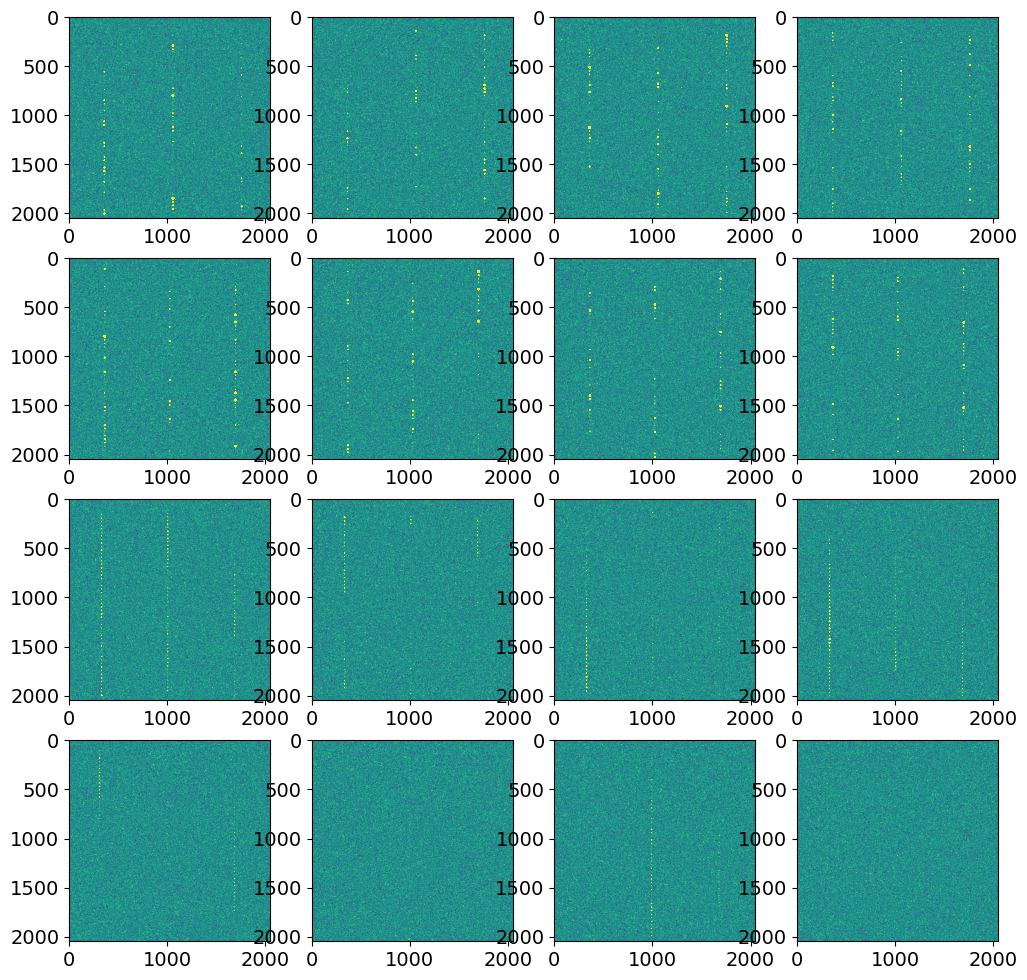

In [27]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

fig = plt.figure(figsize=(12,12))

k = 0

for i in range(4):
    for j in range(4):
        name = "Euclid_DET%i%i.fits" % (i+1,j+1)
        
        hdu = pyfits.open(name)
        print(hdu['SCI'].header)
        hdu.info()
        
        img = hdu['SCI'].data
        print(img.shape)
        head = hdu['SCI'].header
        print(name)
        print(head['CRVAL1'])
        print(head['CRVAL2'])
        print(head['CRPIX1'])
        print(head['CRPIX2'])
        
        #print(np.min(img))
        #print(np.max(img))
        #print(np.mean(img))
        #print(np.median(img))
        #print(np.std(img))
        #print(hdu[name].header)
        #print()
        
        p = fig.add_subplot(4,4,k+1)
        p.imshow(img, vmin=-0.02, vmax=0.02)
        #p.hist(img.flatten(),bins=100)
        #p.set_yscale("log")
        
        k += 1
        
plt.show()


In [ ]:
hdu = pyfits.open("../" + direct)
img = hdu[1].data

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(img,origin="lower",vmin=-0.1,vmax=0.1)
plt.show()

In [ ]:
dir()
print(direct)
print(slitless)

In [ ]:
suffix = "_final"
# updated FITS files
new_direct = direct.replace(".fits",suffix+".fits")
new_slitless = slitless.replace(".fits",suffix+".fits")

dir_exptime = 100.



##############
### DIRECT ###
##############
hdu = pyfits.open("../" + direct)
hdu.info()
#del hdu[ext].header['']

ext = 0
hdu[ext].header['FILTER'] = 'NISP_H'
#hdu[ext].header['INSTRUME'] = 'NISP'
hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
hdu[ext].header['EXPTIME'] = dir_exptime # ????
##hdu[ext].header['EXTVER'] = ext

ext = 1
hdu[ext].header['FILTER'] = 'NISP_H'
#hdu[ext].header['INSTRUME'] = 'NISP' 
hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
hdu[ext].header['EXTVER'] = ext
hdu[ext].header['EXPTIME'] = dir_exptime
hdu.writeto("../" +new_direct, overwrite=True, output_verify='fix')
print("Writing",new_direct)



###############
### SPECTRA ###
###############
hdu = pyfits.open("../" + slitless)
hdu.info()

ext = 0
#hdu[ext].header['INSTRUME'] = 'NISP' 
hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
hdu[ext].header['FILTER'] = 'RED'
hdu[ext].header['EXPTIME'] = spec_exptime

ext = 1
#hdu[ext].header['INSTRUME'] = 'NISP'
hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
hdu[ext].header['FILTER'] = 'RED'
hdu[ext].header['EXTVER'] = ext
hdu[ext].header['EXPTIME'] = spec_exptime

sci = hdu[ext].data
hdu[ext].data = sci/spec_exptime/gain

ext = 2
err = hdu[ext].data
hdu[ext].data = err/spec_exptime/gain


hdu.writeto("../" + new_slitless, overwrite=True, output_verify='fix')
print("Writing",new_slitless)


## Check the pixel scale of the images

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

wcs_pixel_scale(new_direct)
wcs_pixel_scale(new_slitless)

In [ ]:
test = "/Volumes/data5/d2/data/Roman/grizli/run_v7a/Prep/Roman_ATLAS_1deg_cat_all_2022-02-22T12:29:24_RN0_v7_direct_final.fits"

hdu = pyfits.open(test)
hdu.info()

In [ ]:
# remove segmentation FITS to redo "next" step
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
!rm *_seg.fits

In [ ]:
## Make SExtractor catalog
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))


#mag_zero = 25.91
#mag_zero = 26.285
# Euclid ?
mag_zero = 22.0

#direct = new_direct

#for direct in direct_files:
for direct in [new_direct]:

    prefix = direct.replace(".fits","")
    
    sex = "Euclid.sex"
             
    cat = prefix + ".cat" 
    #wht = prefix + "_wht.fits"
    seg = prefix + "_seg.fits"
    bkg = prefix + "_bkg.fits"
    #aper = prefix + "_aper.fits"
    
    if not os.path.exists(seg):
        #os.system('wget http://www.stsci.edu/~brammer/grism/grizli_xdf_sextractor.tar.gz')
        #os.system('tar xzvf grizli_xdf_sextractor.tar.gz')
        
        #sex = prefix + ".sex"
        
        
        wht = direct + "[2]"
        direct_ext = direct + "[1]"
        
        checkimage_name = seg + "," + bkg
        #checkimage_name = seg + "," + bkg + "," + aper
        
        sex_str = 'sex ' + direct_ext + ' -c ' + sex + ' -WEIGHT_IMAGE ' + wht + \
                  ' -CHECKIMAGE_NAME ' + checkimage_name + ' -CATALOG_NAME ' + cat + \
                  ' -MAG_ZEROPOINT %.2f' % (mag_zero)
        os.system(sex_str)
        print(sex_str)

        #os.system('sex hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits ' + 
        #          '-c hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1.sex')
        

# awk '{ printf "circle(%f, %f, 0.00007) # text={%.3f}\n", $4, $5, $42 }' GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat > GRS_FOV1_roll0_dx0_dy0_SCA1_direct.reg
        

In [ ]:
print(cat)
phot = Table.read(cat, format='ascii.sextractor') # ref_cat in multimission
print(phot.colnames)
print(len(phot))

In [ ]:
print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))

fig = plt.figure()
p = fig.add_subplot(111)
p.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
p.set_xlabel("H158 Magnitude")
p.set_ylabel("N")
p.set_xlim(10,32)

In [ ]:
print(phot)

In [ ]:
hdu = pyfits.open(direct)
img = hdu[1].data

x_pix = [pix[0] for pix in pixcrd2]
y_pix = [pix[1] for pix in pixcrd2]

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(img,origin="lower",vmin=-0.1,vmax=0.1)
#p1.scatter(phot["X_IMAGE"],phot["Y_IMAGE"],fc="None",ec="r",s=60)
p1.scatter(x_pix,y_pix,fc="None",ec="b",s=30)
for j,src in enumerate(sources):
    #print(j)
    p1.text(x_pix[j],y_pix[j],src)
plt.show()

In [ ]:
from astropy.table import Table, join, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord

verb = 1
search_rad = 0.6

print("Search primer and all_tbl for RA/DEC matches")
c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
c_phot = SkyCoord(ra=phot["X_WORLD"], dec=phot["Y_WORLD"])

#idx, d2d, d3d = c_prime.match_to_catalog_sky(c_phot)
idx, d2d, d3d = c_phot.match_to_catalog_sky(c_prime)

filt = d2d < 1*u.arcsec

if verb:
    fig = plt.figure()
    p1 = fig.add_subplot(111)
    p1.hist(d2d[filt].value*3600.,bins=25)
        
#primer['idx'] = idx
#primer['d2d'] = d2d

phot['idx'] = idx
phot['d2d'] = d2d
        #print(primer.colnames)
        
#phot['idx'] = np.arange(len(phot))
primer['idx'] = np.arange(len(primer))
        #print(all_tbl.colnames)
        #print(all_tbl['idx'])
        
print("Join all_tbl and primer tables")
match_tbl = join(phot, primer, keys='idx')
        #print(match_tbl)
        #print(match_tbl.colnames)
        
print("Select only sources < %.2f arcsec" % (search_rad))
#filt = match_tbl['d2d'] < 1.0*u.arcsec
clean_filt = match_tbl['d2d'] < search_rad*u.arcsec
match_clean_tbl = match_tbl[clean_filt]
print(list(match_clean_tbl['idx']))
print(len(match_clean_tbl))
        

In [ ]:
hdu = pyfits.open(direct)
img = hdu[1].data

x_pix = [pix[0] for pix in pixcrd2]
y_pix = [pix[1] for pix in pixcrd2]

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(img,origin="lower",vmin=-0.1,vmax=0.1)
#p1.scatter(phot["X_IMAGE"],phot["Y_IMAGE"],fc="None",ec="r",s=60)
p1.scatter(match_clean_tbl['X_IMAGE'],match_clean_tbl['Y_IMAGE'],fc="None",ec="b",s=30)
for j,src in enumerate(match_clean_tbl['SOURCE_ID']):
    #print(j)
    p1.text(match_clean_tbl['X_IMAGE'][j],match_clean_tbl['Y_IMAGE'][j],src)
plt.show()

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
t0 = time.time()

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# allow simulation of objects at the edges
pad=100 # pixels
#pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

mag_limit = 30 

#h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(2048,2048))
#grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

Euclid = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                               ref_file=new_direct, ref_ext=1,
                               seg_file=seg, 
                               #shrink_segimage=False)
                               shrink_segimage=True)

Euclid_cat = Euclid.blot_catalog(phot, sextractor=True) 
Euclid.catalog = Euclid_cat

mask = Euclid_cat['MAG_AUTO'] < mag_limit
print('N=%d' %(mask.sum()))
#Euclid.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask])
#Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask], verbose=True)

t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

## Check simulation
[top](#Table-of-Contents)

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [ ]:
mag_limit = 30

In [ ]:
Euclid_all,Euclid_magcut,Euclid_extract = check_sims(Euclid, mag_limit)

In [ ]:
print(Euclid_extract)

In [ ]:
Euclid.catalog[:20].show_in_notebook()

In [ ]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#r0,d0 = 228.6882041, 6.2969624 # cont src
#r0,d0 = 228.6882147, 6.3239512 #  emission line src
#r0,d0 = 228.6881854, 6.3209442
#r0,d0 = 228.6882128, 6.3028898 
#r0,d0 = 228.6881973, 6.3179116 
r0,d0 = 228.6881976, 6.3149738 


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()


ix = Euclid.catalog['id'] == id
x0, y0 = Euclid.catalog['x_flt'][ix][0], Euclid.catalog['y_flt'][ix][0]
print(Euclid.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Euclid.object_dispersers[id])

is_cgs, spectrum_1d, b = Euclid.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Euclid, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Euclid.model)
if id in Euclid.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

img = cutout.grism.data['SCI']*1
X = img.flatten()
std = np.std(X)
med = np.median(X)

sig = 1.
vmin = med-sig*std
vmax = med+sig*std

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r',vmin=vmin,vmax=vmax)
p1.set_xlabel("X [pixels]")
p1.set_ylabel("Y [pixels]")

#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Euclid.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## 1D Spectral Extraction
[top](#Table-of-Contents)

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(10,6))
p1 = fig.add_subplot(111)
key = "NISP-GLWv1"
w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)


#sf = f/np.nanmax(f)
sf = f
std = np.nanstd(sf)
med = np.nanmedian(sf)

sig = 2.
y0 = med-sig*std
y1 = med+sig*std


p1.text(0.05,0.9,"ID = %i" % (id),transform=p1.transAxes)
p1.plot(w/1.e4, sf, c="k") # linestyle='steps-mid')

#p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
p1.set_ylabel("Flux [Arbitrary]")
p1.set_xlabel("Wavelength [um]")

p1.set_ylim(y0,y1)

## Loop over all objects and fit their redshifts
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))

In [ ]:
# Test 
#Nl = [id for id in phot['NUMBER']][:2]
#Nl = [id for id in Roman_extract['NUMBER']][:2]

# Large Test 
#Nl = [id for id in phot['NUMBER']][:10]
#Nl = [id for id in Roman_extract['NUMBER']][:1000]

# All sources
#Nl = [id for id in phot['NUMBER']]        # original photometry Table
Nl = [id for id in Euclid_extract['NUMBER']] # cleaned Table

# Problem, might need try/except in fitting
print(Nl)

#print(Roman_extract['MAG_AUTO'])

In [ ]:
print()                                                                                     
all_objects = muppy.get_objects()                                                           
print("All objects = %i" % (len(all_objects)))                                              
sum1 = summary.summarize(all_objects)                                                       
summary.print_(sum1)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
full = "Euclid_00045.full.fits"
row = "Euclid_00045.row.fits"
oned = "Euclid_00045.1D.fits"


hdu = pyfits.open(full)
hdu[0].header

hdu = pyfits.open(row)
hdu[0].header

hdu = pyfits.open(oned)
hdu[0].header

In [ ]:
Nl = [39]

In [ ]:
t0 = time.time()

fwhm = 395 # km/s
#t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
#t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
temp0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
temp1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

print(temp0)
print(len(temp0))
print(temp1)
print(len(temp1))

for id in Nl:

    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Euclid.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Euclid, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Euclid.model)
    if id in Euclid.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    
    #############################
    # old lines of code (working)
    #############################   
    #cutout.write_fits() # still learning
    #beam = 'beam__%05d.grism.A.fits' % (id)
    #new_beam = beam.replace(".fits","_GLW.fits")

    #ext = 0
    #hdu = pyfits.open(beam)
    #hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    #hdu.writeto(new_beam,clobber=True)

    #mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    #mb.write_master_fits()
    
    
    ###########################
    # new lines of code to test
    ###########################
    hdu = cutout.write_fits(get_hdu=True)
    ext = 0
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

    beam = 'beam_%05d.grism.A.fits' % (id)
    hdu.writeto(beam,overwrite=True)

    mb = multifit.MultiBeam([beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()
    
    # kludge
    os.remove(beam)
    ###########################
    
    
    

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    #memory_tracker.print_diff()
    
    print()
    #all_objects = muppy.get_objects()
    #print("All objects = %i" % (len(all_objects)))
    #sum1 = summary.summarize(all_objects)
    #summary.print_(sum1)
    

t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

## Updating headers for Grizli and adding "realistic" noise

Grizli looks for specific headers in order to decide with instrument conf file to use.  This also needed for how to scale the photometry and spectrocopy throughput.  

This is also useful for testing multiple conf files (which appears to be the case we are now in).

In [ ]:
direct = direct_files[0]
slitless = slitless_files[0]
print(direct)
print(slitless)

In [ ]:
primer_cat = "Euclid_Roman_4deg2_%s.fits" % (field)
print(primer_cat)
#primer = Table.read(primer_cat, format='ascii.sextractor')
primer = Table.read(primer_cat, format='fits')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

In [ ]:
primer.rename_column('num', 'NUMBER')
primer.rename_column('x_pix', 'X_IMAGE')
primer.rename_column('y_pix', 'Y_IMAGE')
primer.rename_column('m_new', 'MAG_F1600W')

In [ ]:
### Show them!

ncols = 2

all = [direct,new_direct,slitless,new_slitless]
print(all)

#N = len(all)
# not sure why this isn't working
#nrows = -(-N/ncols) # returns ceiling of division
#print(nrows)
nrows = 2

fig = plt.figure()

for i,a in enumerate(all):
    pf = pyfits.open(a)
    image = pf['SCI'].data
    print(np.mean(image),np.median(image),np.std(image))
    

    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.imshow(image, interpolation='Nearest', 
              origin='lower', cmap='inferno',
              vmin=-0.1,vmax=0.1)
    #ax.scatter(primer['X_IMAGE'], primer['Y_IMAGE'], s=100,
    #               edgecolor='green', facecolor='none', alpha=0.7)

fig.tight_layout(pad=0.5)

## Show sources from primer catalogs

In [ ]:
fig = plt.figure(figsize=(10,10))

pf = pyfits.open(direct)
image = pf['SCI'].data
print(np.mean(image),np.median(image),np.std(image))

#filt = primer['MAG_F1600W'] < 20
filt = (primer['MAG_F1600W'] > 20.9) & (primer['MAG_F1600W'] < 21)

    

ax = fig.add_subplot(111)
ax.imshow(image, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.5, cmap='inferno')
ax.scatter(primer['X_IMAGE'][filt], primer['Y_IMAGE'][filt], s=100,
            edgecolor='green', facecolor='none', alpha=0.7)
for i in range(len(primer[filt])):
    ax.text(primer[filt]['X_IMAGE'][i], primer[filt]['Y_IMAGE'][i],"%.2f" % (primer[filt]['MAG_F1600W'][i]),c="green")

fig.tight_layout(pad=0.5)

In [ ]:
primer[filt]['NUMBER','RA','DEC','MAG_F1600W'].show_in_notebook()

In [ ]:
# Random
# 23961 10.0011107466  0.0149484929 18.49
# 8063  10.0412372492  0.0029643496 19.87
# 8990  10.005562076  -0.0566183098 20.79
# 606    9.9664018228 -0.0055298638 20.91 continuum
# 23115  9.958860925  -0.0350264133 20.98
# 2388  10.0098736134 -0.0298934341 21.95
# 21289  9.9912782697 -0.0334312864 22.92
# 12314 10.0110716308  0.05128653   23.97

## Find sources in the direct image
[top](#Table-of-Contents)

Just like the multi-mission, I am using SExtractor to find all of the sources in the direct images. This step is important not only for finding the sources but also for generating the segmentation map which will be used during the extraction of the spectra.

I may eventually adapt this to use SEP just like Grizli, but currently I understand SExtractor a little better.

The re-run the previous step, run this command.  In case you want to change the SExtractor parameters.

In [ ]:
print(new_direct)

### Roman zero point calculation

[aXeSIM_Analysis.ipynb](aXeSIM_Analysis.ipynb)

/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/analysis

In [ ]:
#########################
# copy sextractor files #
#########################

# cd ~/data/Roman/grizli/my_roman_sims/Prep

# rsync -avz Roman.param cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep
# rsync -avz Roman.sex   cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep
# rsync -avz default.nnw cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep

This a temporary. Around here is where I would loop over all of the detectors. 

In [ ]:
print(cat)

## Read SExtractor Photometry of Direct Images
[top](#Table-of-Contents)

In [ ]:
filt = (phot['MAG_AUTO'] > 24) & (phot['MAG_AUTO'] < 25)
phot['NUMBER','X_WORLD','Y_WORLD','MAG_AUTO'][filt].show_in_notebook()



# random
ids = [4986, 3413, 2182, 387, 2349]
#print(phot["NUMBER"] == ids)

[phot[phot["NUMBER"] == id]['X_WORLD','Y_WORLD'].copy() for id in ids]
#print(phot['X_WORLD','Y_WORLD'][ids])


#id = phot['NUMBER'][np.argmin(dr)]
#obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
#print('ID:%d, mag=%.2f' %(id, obj_mag))

In [ ]:
print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))

fig = plt.figure()
p = fig.add_subplot(111)
p.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
p.set_xlabel("H158 Magnitude")
p.set_ylabel("N")
p.set_xlim(10,32)

## (TESTING) Fake segmentation image - SKIP

In [ ]:
# create fake segmentation

yl, xl = 4088, 4088
#seg = np.zeros((yl, xl))

id = 6572
#r0, d0 = 53.2356312, -27.8250528 # emission line object?
x0, y0 = 1208.681132551118, 1574.86233818024
r = 45 # pixels

seg_img = create_circular_mask(yl,xl,[x0,y0],r)*id
print(seg_img)

seg = "seg.fits"
hdu = pyfits.PrimaryHDU(seg_img,header=head)
#hdu.verify('warn')''
hdu.writeto(seg,clobber=True)

In [ ]:
# display segmentation
ext = 0
pf = pyfits.open(seg)
seg_img = pf[ext].data


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(seg_img)

In [ ]:
phot = phot[phot["NUMBER"] == id]
print(phot)

## Roman object simulation
[top](#Table-of-Contents)

In [ ]:
##############################
# compare branch differences #
##############################

# git diff roman_sims_v1_gwalth..master -- *.py

# cd ~/python/grizli_1.3.2/grizli

# rsync -avz grismconf.py cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz model.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz multifit.py  cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz utils.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli


In [ ]:
#########################
# copy grism conf files #
#########################

# cd ~/data/Roman/grizli/grizli/CONF

# rsync -avz Roman.G150-v?-GLW.conf cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF
# rsync -avz sens_0720_2020.fits    cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF

In [ ]:
t0 = time.time()

### Roman GRS grism
# allow simulation of objects at the edges
#pad=0 # pixels
pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

# using the ZP Anihita gave me for the direct image

# sims              old  new 
#mag_limit = 18 #    34   11
#mag_limit = 20 #   273   49
#mag_limit = 22 #  1599  334 
#mag_limit = 24 #  5177 1830
#mag_limit = 26 # 10015 5704
#mag_limit = 28 #       7172


mag_limit = 30 

#h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(2048,2048))
#grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                              ref_file=new_direct, ref_ext=1,
                              seg_file=seg, shrink_segimage=True)

Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
Roman.catalog = Roman_cat

mask = Roman_cat['MAG_AUTO'] < mag_limit
print('N=%d' %(mask.sum()))
#Roman.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
#Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask], verbose=True)

t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
t0 = time.time()

print(Roman)

import pickle

# ~ 5GB file
with open('Roman_GrismFLT.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Roman, f, pickle.HIGHEST_PROTOCOL)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
t0 = time.time()

import pickle

with open('Roman_GrismFLT.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    Roman = pickle.load(f)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
print(Roman)
print(Roman.__dict__)

In [ ]:
print()
all_objects = muppy.get_objects()
print("All objects = %i" % (len(all_objects)))
sum1 = summary.summarize(all_objects)
summary.print_(sum1)

## (TESTING) Roman pad and magnitude test - SKIP

In [ ]:
### Roman GRS grism

# test set
#pads = [0]
#mag_limits = [18,20]

pads = [0,100,200,400,800]
mag_limits = [18,20,22,24,26]

info_list = []
cat_list = []
i = 0 # iter
N = len(pads) * len(mag_limits) # total iter

for pad in pads:
    for mag_limit in mag_limits:

        Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                                      ref_file=new_direct, ref_ext=1,
                                      seg_file=seg, shrink_segimage=True)

        Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
        Roman.catalog = Roman_cat

        mask = Roman_cat['MAG_AUTO'] < mag_limit
        Ntot = mask.sum()
        
        Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
        
        ids_ext = []
        for id in Roman.object_dispersers:
            is_cgs, spectrum_1d, beam = Roman.object_dispersers[id]
            if len(beam) > 0: 
                ids_ext.append(id)
        
        ids_ext = np.array(ids_ext)
        Next = len(ids_ext)
        
        print()
        print('iter = %i of %i' % (i+1,N))
        print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
        print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))
        print("\n")
        
        info_list.append([pad, mag_limit, Ntot, Next])
        
        Roman_extract = Roman.catalog[ids_ext - 1] 
        cat_list.append(Roman_extract)
        
        fig = plt.figure(figsize=[20,10])
        # Direct
        ax1 = fig.add_subplot(121)
        ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')
        ax1.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
                   edgecolor='white', facecolor='none', alpha=0.7)
        ax1.set_xticklabels([])
        ax1.set_title('pad=%d  mag_limit=%d  Ntot=%d  Next=%d' %(pad,mag_limit,Ntot,Next))

        # Grism
        ax2 = fig.add_subplot(122)
        ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
        ax2.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
                   edgecolor='green', facecolor='none', alpha=0.7)
        ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
        fig.tight_layout(pad=4.0)   
        
        i += 1
        
#print(info_list)


print("\n\n")
print("#"*12)
print("Test summary")
print("#"*12)
print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
for info in info_list:
    pad, mag_limit, Ntot, Next = info
    print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))

print()
print(len(cat_list))
#print(cat_list)

In [ ]:
#wcs = pywcs.WCS(head)

## Show direct images and slitless spectra
[top](#Table-of-Contents)

In [ ]:
### Show them!

fig = plt.figure(figsize=[10,20])
# Direct
axt = fig.add_subplot(211)
axt.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.1, cmap='inferno')
# Grism
axb = fig.add_subplot(212)
axb.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', cmap='gray_r', vmin=-0.02, vmax=0.02)
axb.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
    

axt.set_yticklabels([])
axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

## Show direct images and slitless spectra (with sources overplotted)

This is a check to see if there is a field dependence (or magnitude) to the failed simulations.

In [ ]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,20])

#Roman_extract = Roman.catalog[0][0]

# Direct
#ax1 = fig.add_subplot(211, projection=wcs)
ax1 = fig.add_subplot(211)
ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='viridis')

ax1.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
           edgecolor='white', facecolor='none', alpha=0.5)

#ax1.set_xticklabels([])
print(ax1.get_xlim())
print(ax1.get_ylim())
    
# Grism
#ax2 = fig.add_subplot(212, projection=wcs)
ax2 = fig.add_subplot(212)
ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='gray_r')

ax2.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
           edgecolor='green', facecolor='none', alpha=0.5)


ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
print(ax2.get_xlim())
print(ax2.get_ylim())

fig.tight_layout(pad=4.0)

In [ ]:
print(phot.colnames)
print(phot["X_WORLD","Y_WORLD"])
print(phot["MAG_AUTO"])

## (TESTING) Filter catalog based on position on the detector and magnitude - SKIP

In [ ]:
# OLD - DO NOT RUN!

cat = Roman.catalog
cat["NUMBER","MAG_AUTO","id","ra","dec","x_flt","y_flt"]
#cat.colnames

x_filt = (cat['x_flt'] > 2400) & (cat['x_flt'] < 2600)
y_filt = (cat['y_flt'] > 3900) & (cat['y_flt'] < 4100)
mag_filt = (cat['MAG_AUTO'] < 24)

filt = x_filt & y_filt & mag_filt

print(cat[filt]['MAG_AUTO','id',"ra","dec","x_flt","y_flt"])

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
from importlib import reload
reload(grizli.model)

## Cygnusc redshift fitting and memory testing

In [ ]:
from grizli_functions import grizli_fit_all_z,grizli_fit_all_z_async,grizli_fit_all_z_sync          
from grizli_functions import grizli_fit_all_z_2, grizli_fit_all_z_3                                 
from grizli_functions import test_func,test_func_sync                                               
from grizli_functions import get_sim_info

In [ ]:
# source list                                                                                       
sources = np.array(get_sim_info())                                                                  
print(sources)                                                                                      
print(len(sources))
                                                    
filt = sources < 10 # where I quit (memory leak somewhere...)                                      
#print(sources[filt])                                                                               
#print(len(sources[filt]))                                                                          
                                                                                                    
sources = list(sources[filt])                                                                       
#sources = list(sources)      

grizli_fit_all_z_3(HOME_PATH='/home/gwalth/data/Roman/grizli/sims/',                                
                 field="field_0017", root='sim_v3',z2=6.0, sources=sources)

In [ ]:
print(type(Roman))

## Inspect Redshift Fitting Results
[top](#Table-of-Contents)

In [ ]:
def redshift_analysis_od(root,id,save_lines=3):

    full_obj = OrderedDict()
   
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    h0 = full_hdu[0].header
    line_keys = ['ID','RA','DEC','REDSHIFT','NUMLINES']
    #print(h0)
    for lk in line_keys:
        #h0[lk],h0.comments[lk]
        #print(h0[lk],)
        full_obj[lk] = h0[lk]
    
    # read all of the lines
    #print(h0['NUMLINES'])
    lines_list = []
    for i in range(h0['NUMLINES']):
        #print(i+1)
        od = OrderedDict({"line":h0["LINE%03d" % (i+1)],
                          "flux":h0["FLUX%03d" % (i+1)],
                          "err":h0["ERR%03d" % (i+1)]})                  
        lines_list.append(od)
                          
                          
    #print(lines_list)
    line_tbl = Table(lines_list)
    line_tbl.sort("flux")
    line_tbl.reverse()
    
    for i in range(save_lines):
        try:
            full_obj["LINE%03d" % (i+1)] = line_tbl['line'][i]
            full_obj["FLUX%03d" % (i+1)] = line_tbl['flux'][i]
            full_obj["ERR%03d" % (i+1)] = line_tbl['err'][i]
        except IndexError:
            full_obj["LINE%03d" % (i+1)] = "None"
            full_obj["FLUX%03d" % (i+1)] = 99.9
            full_obj["ERR%03d" % (i+1)] = -99.9
    
    
    h1 = full_hdu['ZFIT_STACK'].header
    zfit_keys = ['CHIMIN','DOF','Z02','Z16','Z50','Z84','Z97','ZWIDTH1',
                 'ZWIDTH2','Z_RISK','MIN_RISK','Z_MAP','GAM_LOSS']
    
    for zfk in zfit_keys:
        #h1[zfk],h1.comments[zfk]
        #print(h1[zfk],)
        full_obj[zfk] = h1[zfk]
    
    return full_obj
    


In [ ]:
def plot_redshifts(tbl):

    fig = plt.figure()
    p1 = fig.add_subplot(111)
    p1.scatter(tbl["ZWIDTH1"], tbl["ZWIDTH2"])

    p1.plot([0.0001,10.0],[0.05,0.05],"--",c="k")
    p1.plot([0.05,0.05],[0.0001,10.0],"--",c="k")

    p1.set_xlabel("zwidth1 [16th and 84th p(z) percentile]")
    p1.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
    p1.set_xscale("log")
    p1.set_yscale("log")
    p1.set_xlim(0.0001,10.0)
    p1.set_ylim(0.0001,10.0)

    fig = plt.figure(figsize=(12,4))
    p1 = fig.add_subplot(121)
    p1.scatter(tbl["REDSHIFT"], tbl["ZWIDTH1"])
    #p1.plot([0,3.5],[0.1,0.1],"--",c="k")
    p1.plot([0,3.5],[0.05,0.05],"--",c="k")
    p1.set_xlabel("Redshift")
    p1.set_ylabel("zwidth1 [16th and 84th p(z) percentile]")
    p1.set_yscale("log")
    p1.set_ylim(0.0001,10.0)

    p2 = fig.add_subplot(122)
    p2.scatter(tbl["REDSHIFT"], tbl["ZWIDTH2"])
    #p2.plot([0,3.5],[0.1,0.1],"--",c="k")
    p2.plot([0,3.5],[0.05,0.05],"--",c="k")
    p2.set_xlabel("Redshift")
    p2.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
    p2.set_yscale("log")
    p2.set_ylim(0.0001,10.0)
    
    print(len(tbl))

In [ ]:
def plot_redshifts2(tbl,zcut=0.01):

    filt1 = tbl["ZWIDTH1"] < zcut
    tbl_filt1 = tbl[filt1]

    fig = plt.figure(figsize=(12,10))

    p1 = fig.add_subplot(221)
    p1.scatter(tbl["REDSHIFT"], tbl["ZWIDTH1"], s=2, c="k")
    p1.scatter(tbl_filt1["REDSHIFT"], tbl_filt1["ZWIDTH1"])
    #p1.plot([0,3.5],[0.1,0.1],"--",c="k")
    p1.plot([0,3.5],[zcut,zcut],"--",c="k")
    p1.set_xlabel("Redshift")
    p1.set_ylabel("z$_{width1}$ [16th and 84th p(z) percentile]")
    p1.set_yscale("log")
    p1.set_ylim(0.0001,10.0)

    p2 = fig.add_subplot(222)
    p2.scatter(tbl["REDSHIFT"], tbl["MAG_AUTO"], s=2, c="k")
    p2.scatter(tbl_filt1["REDSHIFT"], tbl_filt1["MAG_AUTO"])
    #p2.plot([0,3.5],[0.1,0.1],"--",c="k")
    #p2.plot([0,3.5],[0.05,0.05],"--",c="k")
    p2.set_xlabel("Redshift")
    p2.set_ylabel("Mag")
    #p2.set_yscale("log")
    #p2.set_ylim(0.0001,10.0)

    filt2 = tbl["ZWIDTH2"] < zcut
    tbl_filt2 = tbl[filt2]

    p3 = fig.add_subplot(223)
    p3.scatter(tbl["REDSHIFT"], tbl["ZWIDTH2"], s=2, c="k")
    p3.scatter(tbl_filt2["REDSHIFT"], tbl_filt2["ZWIDTH2"])
    #p3.plot([0,3.5],[0.1,0.1],"--",c="k")
    p3.plot([0,3.5],[zcut,zcut],"--",c="k")
    p3.set_xlabel("Redshift")
    p3.set_ylabel("z$_{width2}$ [2.5th and 97.5th p(z) percentile]")
    p3.set_yscale("log")
    p3.set_ylim(0.0001,10.0)

    p4 = fig.add_subplot(224)
    p4.scatter(tbl["REDSHIFT"], tbl["MAG_AUTO"], s=2, c="k")
    p4.scatter(tbl_filt2["REDSHIFT"], tbl_filt2["MAG_AUTO"])
    #p4.plot([0,3.5],[0.1,0.1],"--",c="k")
    #p4.plot([0,3.5],[0.05,0.05],"--",c="k")
    p4.set_xlabel("Redshift")
    p4.set_ylabel("Mag")
    #p4.set_yscale("log")
    #p4.set_ylim(0.0001,10.0)

    print(len(tbl))
    print(len(tbl[filt1]))
    print(len(tbl[filt2]))
    
    return filt1,filt2


Important note:

In the in initial catalog generation, I need RA and DEC or some other identifier to push along and tag the sources properly for their magnitudes and redshifts.  If I can map the sources correctly then I should be able to adjust any magnitude differences.

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
#print(ids)
print("N =",len(ids))

In [ ]:
print(ids)

In [ ]:
#ids = [652, 653]

Takes ~2 min to read 1000 files into a table

In [ ]:
redshift_rows = []
for id in ids:
    redshift_od = redshift_analysis_od(root,id,save_lines=5)
    redshift_rows.append(redshift_od)

redshift_fits = Table(redshift_rows)
print(redshift_fits)

In [ ]:
print(redshift_fits.colnames)

ind = 1
print(redshift_fits['LINE%03d' % ind])
print(redshift_fits['FLUX%03d' % ind])
print(redshift_fits['ERR%03d' % ind])

print(np.min(redshift_fits['FLUX%03d' % ind]))
print(np.max(redshift_fits['FLUX%03d' % ind]))


### Description of tables

The available tables for analysis

phot          - SExtractor table
Roman         - Grizli data
Roman_all     - output of check_sims, all sources
Roman_magcut  - output of check_sims, only sources above the magnitude cut
Roman_extract - output of check_sims, only sources extracted
redshift_fits - all the redshift fits of the Roman_extract (full.fits) read into a table
primer        - original input sources and true redshifts


Roman_extract, redshift_fits and primer need to be joined into one table

Roman_extract and redshift_fits can be joined based on SExtractor id --> all_tbl
primer needs to be joined based on RA,Dec  


all_tbl         - join between Roman_extract and redshift_fits
match_tbl       - join between all_tbl and primer
match_clean_tbl - sources outside of match radius removed (>1")

In [ ]:
print(redshift_fits.colnames)
#print(redshift_fits['ID'])

In [ ]:
print(Roman_extract.colnames)
#print(Roman_extract['NUMBER','id'])

In [ ]:
print(primer.colnames)
#print(primer['NUMBER'])

In [ ]:
Roman_extract.rename_column('NUMBER', 'ID')

In [ ]:
all_tbl = join(Roman_extract, redshift_fits, keys='ID')
print(all_tbl)

In [ ]:
#plot_redshifts(all_tbl)
zfilt1,zfilt2 = plot_redshifts2(all_tbl)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.01)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.005)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.001)

<b>Skip</b> One matching method

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
c_all = SkyCoord(ra=all_tbl["RA"]*u.degree, dec=all_tbl["DEC"]*u.degree)
#idx_c_prime, idx_c_all, d2d, d3d = c_all.search_around_sky(c_prime, 5*u.arcsec)
idx_c_prime, idx_c_all, d2d, d3d = c_all.search_around_sky(c_prime, 1*u.deg)

#np.all(d2d < 5*u.arcsec)

#dist_filt = d2d < 1.0*u.arcsec
dist_filt = d2d < 1.0*u.deg

print(idx_c_prime[dist_filt])
print(len(idx_c_prime[dist_filt]))
print(idx_c_all[dist_filt])
print(len(idx_c_all[dist_filt]))

Another matching method (preferred)

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
c_all = SkyCoord(ra=all_tbl["RA"]*u.degree, dec=all_tbl["DEC"]*u.degree)

idx, d2d, d3d = c_prime.match_to_catalog_sky(c_all)


print(idx)
print(d2d)
print(len(idx))
print(len(c_prime))
print(len(c_all))

filt = d2d < 1*u.arcsec

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.hist(d2d[filt].value*3600.,bins=20)

In [ ]:
primer['idx'] = idx
primer['d2d'] = d2d
print(primer.colnames)

In [ ]:
all_tbl['idx'] = np.arange(len(all_tbl))
print(all_tbl.colnames)
#print(all_tbl['idx'])

In [ ]:
match_tbl = join(all_tbl, primer, keys='idx')
#print(match_tbl)

In [ ]:
#filt = match_tbl['d2d'] < 1.0*u.arcsec
filt = match_tbl['d2d'] < 0.4*u.arcsec
match_clean_tbl = match_tbl[filt]
print(len(match_clean_tbl))

In [ ]:
z_fit = match_clean_tbl["REDSHIFT_1"]
z_true = match_clean_tbl["REDSHIFT_2"]

mag_fit  = match_clean_tbl["MAG_AUTO"]
mag_true = match_clean_tbl["MAG_F1600W"]

filt = match_clean_tbl["MAG_AUTO"] < 24

In [ ]:
fig = plt.figure(figsize=(12,12))

p1 = fig.add_subplot(221)
p1.scatter(z_fit, z_true, s=5, c="k")
p1.scatter(z_fit[filt], z_true[filt], s=30, c="orange",alpha=0.5)
p1.plot([0.05,3.05],[0.0,3.0],"--",c="b",alpha=0.5)
p1.plot([0.0,3.0],[0.05,3.05],"--",c="b",alpha=0.5)
p1.set_xlim(0,3)
p1.set_ylim(0,3)
p1.set_xlabel("Fit redshift")
p1.set_ylabel("True redshift")

p2 = fig.add_subplot(222)
p2.scatter(mag_fit, mag_true, s=5, c="k")
p2.plot([19.2,30.2],[19,30],"--",c="b",alpha=0.5)
p2.plot([19,30],[19.2,30.2],"--",c="b",alpha=0.5)
p2.set_xlim(19,30)
p2.set_ylim(19,30)
p2.set_xlabel("Measured mag")
p2.set_ylabel("True mag")

p3 = fig.add_subplot(223)
p3.hist(z_fit)
p3.set_xlabel("Fit redshift")

p4 = fig.add_subplot(224)
p4.hist(z_true)
p4.set_xlabel("True redshift")

In [ ]:
dz = (z_true - z_fit)/(1+z_true)

fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
p1.hist(dz,bins=100)

#p1.hist(dz,bins=1000)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

In [ ]:
match_clean_tbl['SN001'] = match_clean_tbl['FLUX001']/match_clean_tbl['ERR001']
match_clean_tbl['SN002'] = match_clean_tbl['FLUX002']/match_clean_tbl['ERR002']
match_clean_tbl['SN003'] = match_clean_tbl['FLUX003']/match_clean_tbl['ERR003']
match_clean_tbl['SN004'] = match_clean_tbl['FLUX004']/match_clean_tbl['ERR004']
match_clean_tbl['SN005'] = match_clean_tbl['FLUX005']/match_clean_tbl['ERR005']

fig = plt.figure(figsize=(12,5))
p1 = fig.add_subplot(111)
p1.hist(match_clean_tbl['SN001'],bins=400,label="LINE001",alpha=0.7)
p1.hist(match_clean_tbl['SN002'],bins=400,label="LINE002",alpha=0.7)
p1.hist(match_clean_tbl['SN003'],bins=200,label="LINE003",alpha=0.7)
p1.hist(match_clean_tbl['SN004'],bins=200,label="LINE005",alpha=0.7)
p1.hist(match_clean_tbl['SN005'],bins=200,label="LINE005",alpha=0.7)
p1.set_xlabel("S/N")
p1.set_xlim(0,15)
p1.legend()

In [ ]:
filt1 = match_clean_tbl['SN001'] > 6.5
print("Num. sources (S/N > 6.5) =",len(match_clean_tbl['SN001'][filt1]))

match_clean_sn65_tbl = match_clean_tbl[filt1]
print("Num. sources w/ 2 lines (S/N > 3)")
filt2 = match_clean_sn65_tbl['SN002'] > 3
print(len(match_clean_sn65_tbl[filt2]))

print("Num. sources w/ 3 lines (S/N > 3)")
filt3 = match_clean_sn65_tbl['SN003'] > 3
print(len(match_clean_sn65_tbl[filt3]))



In [ ]:
def sample_numbers(tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005):
    
    filt = tbl[sn_key] > sn
    
    print('Num. sources =',len(tbl[sn_key]))
    print('Num. sources (S/N > %.1f) =' % (sn),len(tbl[sn_key][filt]))
    
    z_fit = tbl["REDSHIFT_1"][filt]
    z_true = tbl["REDSHIFT_2"][filt]

    dz = (z_true - z_fit)/(1+z_true)

    #zfilt = np.abs(dz) < sigma_dz
    zfilt = np.abs(dz) < sigma_dz*(1+z_true)

    tbl_sn = tbl[filt]
    tbl_sn_dz = tbl_sn[zfilt]

    print("Num. sources (dz < %.3f) =" % (sigma_dz),len(z_fit[zfilt]))
    print("Frac. sources (dz < %.3f) = %.4f" % (sigma_dz,len(z_fit[zfilt])/len(z_fit)))
    print()
    
    fig = plt.figure(figsize=(4,4))
    p1 = fig.add_subplot(111)
    p1.hist(z_fit,bins=15,label="all")
    p1.hist(z_fit[zfilt],bins=15,label="z < %.3f" % (sigma_dz))
    p1.set_xlabel("redshift")
    p1.legend()
    plt.show()
    

In [ ]:
sample_numbers(match_clean_tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005)
sample_numbers(match_clean_tbl, sn_key='SN001', sn=5.0, sigma_dz=0.005)
sample_numbers(match_clean_tbl, sn_key='SN001', sn=3.0, sigma_dz=0.005)

In [ ]:
fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
#p1.hist(dz,bins=100)

p1.hist(dz,bins=200)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

In [ ]:
from collections import Counter

def emline_bar_chart(data,title=""):

    c1 = Counter(data)
    c2 = OrderedDict(c1.most_common())

    ind = np.arange(len(c1))
    width=0.75

    fig = plt.figure()
    p1 = fig.add_subplot(111)
    p1.bar(ind, c2.values(), width)
    p1.set_xticks(ind)
    p1.set_xticklabels(c2.keys(), rotation = 90)
    p1.set_title(title)
    plt.show()
    
def emline_bar_chart2(data1,data2,title=""):

    c1 = Counter(data1)
    c1o = OrderedDict(c1.most_common())
    
    c2 = Counter(data2)
    c2o = OrderedDict(c2.most_common())
    
   
    ind1 = np.arange(len(c1))
    ind2 = np.arange(len(c2))
    width=0.75

    fig = plt.figure(figsize=(12,6))
    p1 = fig.add_subplot(121)
    p1.bar(ind1, c1o.values(), width)
    p1.set_xticks(ind1)
    p1.set_xticklabels(c1o.keys(), rotation = 90)
    p1.set_title(title)
    
    p2 = fig.add_subplot(122)
    p2.bar(ind2, c2o.values(), width)
    p2.set_xticks(ind2)
    p2.set_xticklabels(c2o.keys(), rotation = 90)
    p2.set_title(title)
    plt.show()
    
    plt.show()


In [ ]:
emline_bar_chart2(match_clean_tbl['LINE001'],match_clean_sn65_dz005_tbl['LINE001'], 
                  title = "1st brightest line")

#emline_bar_chart(match_clean_tbl['LINE001'],title = "1st brightest line")
emline_bar_chart(match_clean_tbl['LINE002'],title = "2nd brightest line")
emline_bar_chart(match_clean_tbl['LINE003'],title = "3rd brightest line")
emline_bar_chart(match_clean_tbl['LINE004'],title = "4th brightest line")
emline_bar_chart(match_clean_tbl['LINE005'],title = "5th brightest line")

In [ ]:
print(dir())
#print(__dict__)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

#primer_cat = "ATLAS_1deg_subsample_cat_random_primer.cat"
#primer_cat = "ATLAS_1deg_subsample_primer_small.lis"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#full_hdu.info()
print('id = {0}'.format(id))
print('N = {0}'.format(len(ids)))

In [ ]:
print("Number of extensions", len(full_hdu))
full_hdu['ZFIT_STACK'] # ext=1
full_hdu['COVAR']      # ext=2
full_hdu['TEMPL']      # ext=3
full_hdu['SEG']        # ext=4

In [ ]:
print("Number of extensions =",len(full_hdu))
head = full_hdu[0].header
full_hdu[0].header

In [ ]:
print("Number of extensions =",len(full_hdu))
full_hdu['ZFIT_STACK'].header

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))


def process_full_fits(root,id):
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    head = full_hdu[0].header
    
    numlines = head['NUMLINES']
    redshift = head['REDSHIFT']
    
    lines_list = []
    
    for i in range(numlines):
        line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                                      "flux":head["FLUX%03d" % (i+1)],
                                      "err":head["ERR%03d" % (i+1)]}))
    line_tbl = Tabel(line_list)
    line_tbl.sort("flux")
    line_tbl.reverse()
    
    return line_tbl[:3] # return 3 brightest lines
        
#####################    
    

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
print(ids)
print("N =",len(ids))



N = head['NUMLINES']

line_list = []
for i in range(N):
    line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                                  "flux":head["FLUX%03d" % (i+1)],
                                  "err":head["ERR%03d" % (i+1)]}))
    
#print(line_list)

line_tbl = Table(line_list)


line_tbl["SN"] = line_tbl["flux"]/line_tbl["err"]
print(line_tbl)


filt = line_tbl["SN"] > 2.0
print(line_tbl[filt])
    
    

In [ ]:
N = head['NUMLINES']

line_list = []
for i in range(N):
    line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                      "flux":head["FLUX%03d" % (i+1)],
                      "err":head["ERR%03d" % (i+1)]}))
    
#print(line_list)

line_tbl = Table(line_list)


line_tbl["sn"] = line_tbl["flux"]/line_tbl["err"]
print(line_tbl)

#filt = line_tbl["SN"] > 2.0
#print(line_tbl[filt])
line_tbl.sort("flux")
line_tbl.reverse()

print(line_tbl)

print(line_tbl[:3])

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

id = 25

f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)
print(oned_hdu[1].header)
print(oned_hdu.info())
grism = Table(oned_hdu['GRISM'].data)
print(grism.colnames)

signal = np.sum(grism['flux'])
noise = np.sqrt(np.sum(grism['err']**2))
print(signal)
print(noise)

print(signal/noise)

#full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#print(full_hdu.info())
print(grism['line'])
plt.plot(grism['flat'])

In [ ]:
S_N = []
for id in phot['NUMBER']:
    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    oned_hdu = pyfits.open(f_1d)
    grism = Table(oned_hdu['GRISM'].data)

    signal = np.sum(grism['flux'])
    noise = np.sqrt(np.sum(grism['err']**2))
    S_N.append(signal/noise)

phot['S_N'] = np.array(S_N)

In [ ]:
print(phot['S_N'])

In [ ]:
plt.scatter(phot['S_N'],phot['MAG_AUTO'])

In [ ]:
plt.hist(phot['S_N'],bins=10,range=[0,20])

In [ ]:
filt = phot['S_N'] < 6.5
print(len(phot[filt]))

# Appendix

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

In [ ]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#small 
#r0,d0 = 9.9667504,  0.0240604 # 19.94
#r0,d0 = 9.9542018, -0.0588458 # 21.10
#r0,d0 = 9.9490562, -0.0373860 # 22.13
#r0,d0 = 9.9465051, -0.0405907 # 23.01
#r0,d0 = 9.9589560,  0.0124919 # 23.98

#random                                MAG    ATLAS NUMBER
#r0,d0 = 10.0011107466,  0.0149484929 # 18.49  23961 continuum
#r0,d0 = 10.0412372492,  0.0029643496 # 19.87  8063 mostly continuum
#r0,d0 = 10.005562076,  -0.0566183098 # 20.79  8990 continuum
#r0,d0 =  9.9664018228, -0.0055298638 # 20.91  606 continuum
#r0,d0 = 10.0265397928, -0.0393050944 # 20.97  2118 emission, probably Ha (good!!!), modspec=1752
#r0,d0 =  9.958860925,  -0.0350264133 # 20.98 23115 
#r0,d0 = 10.0098736134, -0.0298934341 # 21.95  2388 emission
#r0,d0 =  9.9912782697, -0.0334312864 # 22.92  21289 emission or contaminate?
#r0,d0 = 10.0110716308,  0.05128653   # 23.97  12314 ?

# 2118 old
# 1571 new
r0,d0 = 10.0265397928, -0.0393050944 # 20.97  Ha (good!!!)


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()


ix = Roman.catalog['id'] == id
x0, y0 = Roman.catalog['x_flt'][ix][0], Roman.catalog['y_flt'][ix][0]
print(Roman.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Roman.object_dispersers[id])

is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
if id in Roman.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r')
#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Roman.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## aXeSIM predictions based on conf file
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

In [ ]:
from grizli import grismconf

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF")
conf = grismconf.load_grism_config("./Euclid.Gred.0.conf")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
x0,y0 = 1024,1024

dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF/CONF11")
conf = grismconf.load_grism_config("./NISP_RGS000_21.conf")
#conf = grismconf.load_grism_config("./NISP_RGS000_21.conf.beamA")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
x0,y0 = 1024,1024

dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
print(os.getcwd())

## Show 2D beam
[top](#Table-of-Contents)

In [ ]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    #axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [ ]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
   
    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [ ]:
# determine flux in Ang for the source in the direct image

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]

f_scale = ab2flux(mab,15800.)

## Simple SN calculations based on the spcontetc
[top](#Table-of-Contents)

In [ ]:
# Per pix S/N=1
mag_per_pix_w0 = 21.9       # 1.00 um
mag_per_pix_w1 = 21.9       # 1.93 um
mag_per_pix_deepest = 22.7  # 1.34 um

In [ ]:
ab2flux(mag_per_pix_w0,10000.)
ab2flux(mag_per_pix_deepest,13400.)

In [ ]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

#|  um  | arcsec |      |exp per Jy|per pix |per resl|1e4 km/s|
fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1)  
    #p.plot(spcontetc_8n['col1'],f8) 

    

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
    
plt.show()

Roughly estimated from spcontetc (>1.4 micron):

<span style="color:red">5 sigma limit = 1.75e-18 erg/s/cm^2/Ang</span>

<span style="color:red">1 sigma limit = 1.00e-18 erg/s/cm^2/Ang</span>


## Simple SN calculations based on the pzcaletc
[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
pzcaletc_1n = Table.read("../etc/pzcaletc_1n.dat",format="ascii")
pzcaletc_8n = Table.read("../etc/pzcaletc_8n.dat",format="ascii")
print(pzcaletc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(2,13):
for n in range(2,3):
    #p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]) # W/m^2
    p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]*1000.) # erg/s/cm^2
    p.plot(pzcaletc_8n['col1'],pzcaletc_8n['col%i' % (n)]*1000.) # erg/s/cm^2

    
#p.legend(fontsize=14)
#p.set_xlim(w1-0.05, w2+0.05)
#p.set_ylim(-1e-21,3e-20)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
    
plt.show()

## Simple SN calculations based on the apttables2021
[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
apt_rad0_0_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.0_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_2_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.2_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_3_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.3_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00']

#for w in wlist:
#    p.plot(apt_rad0_0_zod1_2[w],apt_rad0_0_zod1_2['AB'],label=w) 

p.scatter(apt_rad0_0_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.0')
p.scatter(apt_rad0_2_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.2')
p.scatter(apt_rad0_3_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.3')
    
p.legend(fontsize=14)
p.set_xscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
    
plt.show()

In [ ]:
##############
# My crude ETC
# based on 
# https://roman.gsfc.nasa.gov/science/apttables2021/table-grism.html
##############

# notes:
# might need a fit cutoff to t = 1e7 

from scipy.optimize import leastsq

t = 301.

param = [1,0]
err = 1.0

# y = ax + b
line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00'] # microns

mag_ab_5sig = []

fig = plt.figure()
p = fig.add_subplot(111)

#x = np.log10(apt_rad0_0_zod1_2['1.20'])
y = apt_rad0_2_zod1_2['AB']
for w in wlist:
    print(w)
    x = np.log10(apt_rad0_2_zod1_2[w])

    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])

    mag_ab = line_fn(sol[0],np.log10(t))
    print(mag_ab)
    mag_ab_5sig.append(mag_ab)
    print()

    logt = np.arange(2.0,8.6,0.1)
    mag = line_fn(sol[0],logt)
    

    p.plot(10**logt,mag,c="k")
    p.scatter(10**x,y,label=w,s=50,alpha=0.7)
    
p.legend(fontsize=14)
p.set_xscale("log")

p.set_xlim(400,2.5e8)
p.set_ylim(20.8,27.2)

p.invert_yaxis()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
p1 = fig.add_subplot(121)

warr = 1e4*np.array([float(w0) for w0 in wlist]) # Angstroms


mag_ab_5sig = np.array(mag_ab_5sig)

p1.plot(warr,mag_ab_5sig)
p1.set_xlabel(r'$\lambda$ [Ang]')
p1.set_ylabel(r'mag [AB]')
p1.invert_yaxis()


#p.set_xlim(0,2000)
#p.set_ylim(20,22)
p2 = fig.add_subplot(122)

#flux_5sig = [ab2flux(mag_ab_5sig[i],w0) for i,w0 in enumerate(warr)]
flux_5sig = ab2flux(mag_ab_5sig,warr) 
p2.plot(warr,flux_5sig)

p2.set_xlabel(r'$\lambda$ [Ang]')
p2.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
    
plt.show()

Comparison between spcontetc and apttables2021

In [ ]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1,label='spcontetc 0.2"')  
    #p.plot(spcontetc_8n['col1'],f8) 


p.plot(warr/1e4,flux_5sig,label="apttables2021")

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
p.legend()
    
plt.show()

In [ ]:
def poly_n(p, x):
    p = np.array(p)
    y = np.zeros((x.shape[0],))
    for n in np.arange(p.shape[0]):
        y += p[n]*x**n
    return y

def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    print(pc)
    pc[0] -= y
    print(pc)
    return np.roots(pc)


print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))


img_table = Table()
img_table['AB'] = apt_SN_55sec_zod1_2['AB']
img_table['55'] = apt_SN_55sec_zod1_2['F158']
img_table['75'] = apt_SN_75sec_zod1_2['F158']
img_table['100'] = apt_SN_100sec_zod1_2['F158']


#print(img_table)

t = 141

# SNR ~ t^(0.5)
# time
x = np.sqrt(np.array([55.,75.,100.]))
param = [1, 0]
err = 1.0

line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

fig = plt.figure()
p = fig.add_subplot(111)

SN = [] # at t

###################
# fit for SNR and t
###################
for i,y in enumerate(img_table['55','75','100']):

    # SNR
    y = np.array(list(y))
    
    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])
    
    t0 = np.arange(50,200,0.1)
    snr = line_fn(sol[0],np.sqrt(t0))
    
    mag = np.ones(snr.shape)*img_table['AB'][i]

    p.plot(mag,snr,c="k")
    
    SN.append(line_fn(sol[0],np.sqrt(t)))

img_table['141'] = SN



param = [1,1,1,1]
# mag
x = img_table['AB']
#print(x)
err = np.ones(x.shape)
#err[:5] = 0.01
#err[-5:] = 0.01

err_fn2 = lambda p: (poly_n(p,x) - y)/err
#####################
# fit for SNR and mag
#####################

dict = {}

for i,t0 in enumerate(['55','75','100','141']):
    
    # SNR
    y = 2.5*np.log10(img_table[t0])
    
    sol = leastsq(err_fn2,param,full_output=1)
    print(sol[0])
    
    mag = np.arange(16.5,26.5,0.1)
    snr = 10**(0.4*poly_n(sol[0],mag))
    
    p.plot(mag,snr,c="k")
    print(len(sol[0]))
    
    dict['sol%s' % t0] = sol[0]

#################
# solving for s/n
#################
print(dict)
sol0 = dict['sol141']
print(solve_for_y(sol0,2.5*np.log10(10.0)))


p.scatter(img_table['AB'],img_table['55'],label='55 sec')
p.scatter(img_table['AB'],img_table['75'],label='75 sec')
p.scatter(img_table['AB'],img_table['100'],label='100 sec')
p.scatter(img_table['AB'],SN,label='141 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

In [ ]:
print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

flist = ['F062','F087','F106','F129','F158','F184','F146','F213']

#for f in flist:
#    p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2[f],label=f) 
    #p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2[f],label=f)
    #p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2[f],label=f) 

p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2['F158'],label='55 sec')
p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2['F158'],label='75 sec')
p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2['F158'],label='100 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

## Roman and Euclid Sensitivity Function

[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
print(HOME_PATH)
#os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

### Gabe's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/Roman.G150.v1.6.sens.fits' # Gabe's
sens_cat1 = Table.read(sens_file)
print(sens_cat1.colnames)

### Anahita's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

### AstroDeep Euclid sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/Euclid.Gred.1st.sens.0.fits'
sens_cat3 = Table.read(sens_file)
print(sens_cat3.colnames)

### TIPS Euclid sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/CONF11/SENS_A.fits'
sens_cat4 = Table.read(sens_file)
print(sens_cat4.colnames)

In [ ]:
fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.errorbar(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],yerr=sens_cat1['ERROR'])
#p1.errorbar(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],yerr=sens_cat2['ERROR'])
p1.plot(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],label="Roman (Pandeia)")
p1.plot(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],label="Roman (Anahita's)")
p1.plot(sens_cat3['WAVELENGTH'],sens_cat3['SENSITIVITY'],label="Euclid (AstroDeep)")
p1.plot(sens_cat4['WAVELENGTH'],sens_cat4['SENSITIVITY'],label="Euclid (TIPS)")
#p1.plot(pzcaletc_1n['col1']*1e4,1./(pzcaletc_1n['col%i' % (n)]*1000.)) # erg/s/cm^2
#p1.plot(pzcaletc_8n['col1']*1e4,1./(pzcaletc_8n['col%i' % (n)]*1000.)) # erg/s/cm^2
p1.set_xlim(8750,20750)
p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
p1.legend()

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(6,18))
p1 = fig.add_subplot(311)
p2 = fig.add_subplot(312)
p3 = fig.add_subplot(313)
for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    # normalize to the magnitude in the direct image
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    
    
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    #

    
    # Method 1
    scale = f_scale/np.nansum(f)
    f = f * scale
    e = e * scale
    # Method 2
    #f = (f/np.nanmedian(f)) * f_scale
    # Method 3
    #skysub = f - np.nanmedian(f)
    #f = (skysub/np.nansum(skysub)) * f_scale
    
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    
    
    percent = [1,25,50,75,95,99,99.9]
    for per in percent:
        print("P(%s) = %.2e" % (per,np.nanpercentile(f, per)))
    print()
        
    N = len(f)
        
    print("Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N")
    
    #chunks = 50. # depends on the width of the line?
    chunks = 70.
    for chunk in np.arange(chunks):
        #print("Chunk = %i" % (chunk+1))
        f_sect = f[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        e_sect = e[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect = w[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect0 = w_sect[0]/1.e4
        w_sect1 = w_sect[-1]/1.e4
        
        print("%3i  %.3f  %.3f  %.2e  %.2e  %.2e  %.2e  %.2e  %.2e  %6.1f" % (chunk+1, w_sect0, w_sect1, np.nansum(f_sect), 
              np.nanmean(f_sect), np.nanmedian(f_sect), np.nanstd(f_sect), np.nanmin(f_sect), 
              np.nanmax(f_sect), np.nansum(f_sect)/np.sqrt(np.nansum(e_sect**2))))
        #print()
        
        
    #print("S/N =",np.nanmax(f)/np.nanstd(f))
    
    m_noi = np.nanmean(e)
    S_N = f/m_noi
    
    
    # plot spectrum
    p1.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    p1.plot([w[0]/1e4,w[-1]/1e4],[m_noi,m_noi], c="g")

    # plot line
    p2.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p2.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    #print(f)
    
    # S/N of line
    p3.plot(w/1.e4, S_N, c="b") # linestyle='steps-mid')
    
    # Line flux and S/N
    print()
    w1 = 1.24
    w2 = 1.26
    #w1 = 1.36
    #w2 = 1.37
    #w1 = 1.48
    #w2 = 1.52
    i1 = np.argmin(np.abs(w/1.e4-w1))
    i2 = np.argmin(np.abs(w/1.e4-w2))
    print(i1,i2)
    
    win = w2 - w1
    i0 = np.argmin(np.abs(w/1.e4-(w1-win)))
    i3 = np.argmin(np.abs(w/1.e4-(w2+win)))
    print(i0,i3)
    print()
    

    dw = w[1] - w[0]
    print(dw)
    
    
    line_flux = np.sum(f[i0:i1])*dw
    line_error = np.sqrt(np.sum((e[i0:i1]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        
    
    line_flux = np.sum(f[i1:i2])*dw
    line_error = np.sqrt(np.sum((e[i1:i2]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    
    
    print(integrate.trapz(f[i1:i2],w[i1:i2]))
    
    print()
    
    line_flux = np.sum(f[i2:i3])*dw
    line_error = np.sqrt(np.sum((e[i2:i3]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        

    
    #y0 = np.nanmin(f)
    #y1 = np.nanmax(f)
    #print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    print()
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

#p.legend(fontsize=14)
p2.set_xlim(w1-0.05, w2+0.05)
p2.set_ylim(-1e-21,3e-20)
#p2.set_ylim(-1e-21,1e-21)
p2.set_xlabel(r'$\lambda$ [micron]')
p2.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

p3.set_xlim(w1-0.05, w2+0.05)
p3.set_ylim(-20,120.)
p3.set_xlabel(r'$\lambda$ [micron]')
p3.set_ylabel(r'S/N')

In [ ]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R1 = interpolate.interp1d(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'])
w10,w11 = sens_cat1['WAVELENGTH'][0],sens_cat1['WAVELENGTH'][-1]

R2 = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w20,w21 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

fig = plt.figure()
p1 = fig.add_subplot(111)

for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    print(w)
    
    # Method 4
    
    i10 = np.argmin(np.abs(w-w10))
    i11 = np.argmin(np.abs(w-w11))
    
    i20 = np.argmin(np.abs(w-w10))
    i21 = np.argmin(np.abs(w-w11))
    
    w1 = w[i10:i11]
    f1 = f[i10:i11]
    e1 = e[i10:i11]
    
    w2 = w[i20:i21]
    f2 = f[i20:i21]
    e2 = e[i20:i21]
    
    response1 = [R1(w_el) for w_el in w1]
    
    response2 = [R2(w_el) for w_el in w2]
    
    flux1 = f1/response1
    noise1 = e1/response1
    
    flux2 = f2/response2
    noise2 = e2/response2
    
    
    # plot spectrum
    p1.plot(w1/1.e4, flux1, c="k") # linestyle='steps-mid')
    #p1.plot(w1/1.e4, noise1, c="r") # linestyle='steps-mid')
    p1.plot(w2/1.e4, flux2, c="g") # linestyle='steps-mid')
    #p1.plot(w2/1.e4, noise2, c="r") # linestyle='steps-mid')

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')



In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#primer_number=2118 # old
primer_number=1571 

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (primer_number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (primer_number)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

In [ ]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

#fwhm = 325 # km/s
fwhm = 650 # km/s

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
t0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
t1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

In [ ]:
print(fit.keys())

## Velocity resolution
[top](#Table-of-Contents)

In [ ]:
# https://wfirst.ipac.caltech.edu/sims/Param_db.html#wfi_grism
# R = 461*wav # wav in microns (2pix)

# Euclid
# R = 380*wav # wav in microns

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

# u = (z - z0)*c/(1+z0)
# u = dz*c/(1+z0)
# dz = u(1+z0)/c
# dz = delta_wav/wav * (1+z0)

 
R = 380 # Euclud
#R = 461 # Roman

u = lambda wav: c/(R*wav)

winc = 0.25
w = np.arange(1.0,2.0+winc,winc)
for w0 in w:
    print("v = %.2f km/s (%.2f micron)" % (u(w0),w0))

print()   
for w0 in w:
    print("R = %.2f (%.2f micron)" % (R*w0,w0))

print()
z = 1.
print("z = %.2f" % (z))
for w0 in w:
    print("dz = %.6f (%.2f micron)" % (u(w0)*(1+z)/c,w0))

    
# R = wav/delta_wav
# R = 461*wav # microns
# 1/delta_wav = 461
# delta_wav = 1/461. 
print()
print("delta_wav = %.7f microns" % (1/R))
print("delta_wav = %.3f Angstroms" % (1/R*10000.))




In [ ]:
# dz = delta_wav/wav * (1+z0)

dz = 10/12400.* (1+0.88615)
print(dz)

## Fit redshift to source
[top](#Table-of-Contents)

In [ ]:
fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

## Display Redshift Fit
[top](#Table-of-Contents)

In [ ]:
display_grizli(root, id, w0=0.8, w1=2.0, labels=1)

## Compare to primer

In [ ]:
print(root,id)

# Primer redshift
filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
z_true = primer["REDSHIFT"][filt]
print("z_true = %.6f" % (z_true))


# Redshift fit to the spectrum
full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
head = full_hdu[0].header
z_fit = head['REDSHIFT']
print("z_fit  = %.6f" % (z_fit))

dz = z_true - z_fit
print("dz     = %.6f" % (dz))

In [ ]:
#print(primer)
print(primer.keys())
modspec_number = 8127
#print(primer_number)
#print(primer[modspec_number-1])

filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
print(primer[filt])
print(primer["REDSHIFT"][filt])

filt = primer["SPECTEMP"] == modspec_number # MODSPEC NUMBER
print(primer[filt])

## Parallel Tests
[top](#Table-of-Contents)

In [ ]:
import multiprocessing as mp
import time

import numpy as np
#from time import time

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
mp.cpu_count()

In [ ]:
t0 = time.time()
results = [howmany_within_range(row, 4, 8) for row in data]
t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

In [ ]:
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

## Parallel Redshift Fitting Tests
[top](#Table-of-Contents)

In [ ]:

#def fit_redshift_parallel(id, grismflt, temp0, temp1, fwhm, root):
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        
    
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#for id in phot['NUMBER'][:3]:

# This breaks if there is a magnitude cut!!!
#Narr = phot['NUMBER']

#t0 = time.time()
Narr = phot['NUMBER'][:5]
#[fit_redshift_parallel(id, Roman, temp0, temp1, fwhm, root) for id in Narr]
#t1 = time.time()
#print(t1-t0,"seconds")


## version 1 
#t0 = time.time()
## Step 1: Init multiprocessing.Pool()
#pool = mp.Pool(mp.cpu_count())

## Step 2: `pool.apply` the `fit_redshift_parallel()`
##[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

#[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

## Step 3: Don't forget to close
#pool.close()
#t1 = time.time()
#print(t1-t0,"seconds")


# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        

In [ ]:
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

In [ ]:
t0 = time.time()
# This breaks if there is a magnitude cut!!!
Narr = phot['NUMBER'][:40]
[fit_redshift_parallel(id, fwhm, root) for id in Narr]
t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
Narr = phot['NUMBER'][:40]

# version 1 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `fit_redshift_parallel()`
#[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

# Step 3: Don't forget to close
pool.close()
t1 = time.time()
print(t1-t0,"seconds")



In [ ]:
print(results)

In [ ]:
Narr = phot['NUMBER'][:40]

# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


## Coordinates check
[top](#Table-of-Contents)

In [ ]:
fig = plt.figure(figsize=[10,10])

mag_limit = 25

filt_pri = primer['MAG_F1600W'] < mag_limit
filt_sex = phot['MAG_AUTO'] < mag_limit

ax = fig.add_subplot(111)
ax.scatter(primer['RA'][filt_pri], primer['DEC'][filt_pri], s=20,
               edgecolor='green', facecolor='none', alpha=0.8, label="Primer")
ax.scatter(phot['X_WORLD'][filt_sex], phot['Y_WORLD'][filt_sex], s=100,
               edgecolor='orange', facecolor='none', alpha=0.7, label="SExtractor")

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.invert_xaxis()

ax.legend(loc=1)

<span style="color:red">
Different sims may have different WCS centers!
</span>
Use this test as a way to check the correct center was used.


aXeSIM conf | hdf5
:----------:|:---:
Roman.G150.wcs_v1.RN0.conf | galacticus_ATLAS_1deg2_subsample.hdf5  
Roman.G150.wcs_v2.RN0.conf | galacticus_ForGreg.hdf5

## SED check

[top](#Table-of-Contents)

In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")

p1.set_xlabel("Wavelength [Ang]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
AXE_PATH = "/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep/"

axe_image = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_images.fits"
axe_spec = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_spectra.fits"

In [ ]:
f = AXE_PATH + axe_spec
pf = pyfits.open(f)
N = len(pf)

#number = 2118 # old
number = 1571

for i in np.arange(N)+1:
    
    head = pf[i].header
    
    specname = head['SPECNAME']
    extname = head['EXTNAME']
    mag_ab = head['MAG_AB']
    
    number_found = int(specname.split("_")[-1])
    if number == number_found:
        print(i,number_found)
    
    # SPECNAME= 'ATLAS_1deg_spec_029260' / Name of spectrum 

    #tab = pf[ext].data
    #flux = tab["flux"]
    #wav = tab["wav_nm"]

In [ ]:
f = AXE_PATH + axe_spec
#f = axe_spec
#ext = 4468 # old
ext = 8127
pf = pyfits.open(f)
print(len(pf))

#print(key)

tab = pf[ext].data

flux = tab["flux"]
wav = tab["wav_nm"]


delta_wav = 1/461. # microns
delta_wav *= 1000. # nm


################################################
# convolve with the resolution of the instrument
################################################
# from iris_snr_sim (essentially from Tuan Do)

delt = 2.0*(delta_wav)/(wav[1]-wav[0])


stddev = delt/2*sqrt(2*log(2))
psf_func = models.Gaussian1D(amplitude=1.0, stddev=stddev)
x = np.arange(4*int(delt)+1)-2*int(delt)
psf = psf_func(x)
psf /= psf.sum() # normalize

new_flux = np.convolve(flux, psf,mode='same')


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(wav,flux,label="aXeSIM spectra",c="r",alpha=0.5)
p1.plot(wav,new_flux,label="Convolved spectra",c="g",alpha=0.8)
# [nm] [erg/s/cm^2/Ang]

#######################
#######################
#######################

# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571 # new

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

p1.plot(specdata["wave"]/10.,specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]

######################
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w0,w1 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
#print(w)
    
# Method 4

i0 = np.argmin(np.abs(w-w0))
i1 = np.argmin(np.abs(w-w1))

w = w[i0:i1]
f = f[i0:i1]
e = e[i0:i1]
    
response = [R(w_el) for w_el in w]
    
flux2 = f/response
noise2 = e/response
    
# plot spectrum
p1.plot(w/10., flux2, c="orange", label="extracted spectra") # linestyle='steps-mid')
# factor of 10 off, could be WAV_AB being wrong (i.e. 1600 instead of 160)

p1.set_xlim(875.0,2075.0)
#p1.set_ylim(1e-15,1e-21)
p1.set_yscale("log")
p1.set_xlabel("Wavelength [nm]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual

p1.legend(loc=1)



pf[ext].header

In [ ]:
f = AXE_PATH + axe_image

ext = 3
pf = pyfits.open(f)
print(len(pf))
pf[ext].header

#tab = pf[ext].data

#fig = plt.figure()
#p1 = fig.add_subplot(111)
#p1.plot(tab["wav_nm"],tab["flux"],label="Input spectra")
## [Ang] [erg/s/cm^2/Ang]
#p1.set_xlim(875.0,2075.0)
#p1.set_yscale("log")
##p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
##p1.legend()